# Задача
[Соревнование](https://www.kaggle.com/competitions/sberbank-russian-housing-market/overview)

Данные предоставлены Сбербанком, старейшим и крупнейшим банком России. Прогнозирование стоимости недвижимости является критически важной задачей для клиентов банка — арендаторов, застройщиков и кредиторов. Точный прогноз позволяет лучше планировать бюджеты и снижать риски. Сбербанк проводит это соревнование, чтобы привлечь сообщество специалистов по машинному обучению и данным для разработки наиболее точных моделей, способных учесть сложные взаимосвязи между характеристиками жилья и макроэкономическими факторами.

Список фичей из топ-20 с краткими описаниями
- num_room: количество комнат в квартире
- full_sq: общая площадь квартиры (кв. м)
- sport_count_5000: количество спортивных объектов в радиусе 5 км
- sport_count_3000: количество спортивных объектов в радиусе 3 км
- trc_count_5000: количество торгово-развлекательных центров (ТРЦ) в радиусе 5 км
- zd_vokzaly_avto_km: расстояние до ближайшего автовокзала (км)
- sadovoe_km: расстояние до Садового кольца (км)
- kremlin_km: расстояние до Кремля — центра Москвы (км)
- bulvar_ring_km: расстояние до Бульварного кольца (км)
- sport_count_2000: количество спортивных объектов в радиусе 2 км
- ttk_km: расстояние до Третьего транспортного кольца (км)
- office_sqm_5000: общая площадь офисных помещений в радиусе 5 км
- trc_sqm_5000: суммарная площадь ТРЦ в радиусе 5 км
- sport_count_1500: количество спортивных объектов в радиусе 1.5 км
- nuclear_reactor_km: расстояние до ближайшего ядерного объекта (км)
- sport_objects_raion: число спортивных объектов в районе
- trc_count_3000: количество ТРЦ в радиусе 3 км
- cafe_count_5000_price_1000: количество кафе в радиусе 5 км со средним чеком до 1000 руб.
- stadium_km: расстояние до ближайшего стадиона (км)
- cafe_count_5000_price_1500: количество кафе в радиусе 5 км со средним чеком до 1500 руб.

In [4]:
import os
import sys
import logging
import random
import warnings
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Set, Tuple

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import skew

from tqdm import tqdm
from IPython.display import HTML, display

import networkx as nx

import category_encoders as ce
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import StackingRegressor

from lightautoml.automl.presets.tabular_presets import (
    TabularAutoML,
    TabularUtilizedAutoML,
)
from lightautoml.validation.np_iterators import (
    FoldsIterator,
    TimeSeriesIterator,
)
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task


warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")


def set_all_seeds(seed: int = 22) -> None:
    """Set random seeds for reproducibility."""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


set_all_seeds()

'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/Users/richardgurtsiev/Desktop/projects/auto_ml/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/richardgurtsiev/Desktop/projects/auto_ml/venv/lib/python3.10/site-packages/lightautoml/text/tokenizer.py:21: UserWarning: 'nltk' - package isn't installed
  warnings.warn("'nltk' - package isn't installed")
/Users/richardgurtsiev/Desktop/projects/auto_ml/venv/lib/python3.10/site-packages/lightautoml/transformers/text.py:23: UserWarning: 'fasttext' - package isn't installed
  warnings.warn("'fasttext' - package isn't installed")


## Часто используемые функции

In [5]:
def load_and_prepare_data(
    data_dir: Path,
    train_file: str = "train.csv",
    test_file: str = "test.csv",
    macro_file: str = "macro.csv",
    drop_columns: list[str] | None = None,
    timestamp_col: str = "timestamp"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Загружает, объединяет и подготавливает тренировочный и тестовый датасеты.

    Функция выполняет полный пайплайн начальной подготовки данных:
    - загрузку train, test и macro файлов;
    - объединение train и test с macro по временному признаку;
    - приведение временного столбца к типу datetime;
    - удаление неинформативных или технических признаков.
    """

    # Загрузка данных
    train_data = pd.read_csv(data_dir / train_file)
    test_data = pd.read_csv(data_dir / test_file)
    macro_data = pd.read_csv(data_dir / macro_file)

    # Объединение с макро-данными
    train_data = train_data.merge(macro_data, how="left", on=timestamp_col)
    test_data = test_data.merge(macro_data, how="left", on=timestamp_col)

    # Приведение timestamp к datetime
    train_data[timestamp_col] = pd.to_datetime(train_data[timestamp_col])
    test_data[timestamp_col] = pd.to_datetime(test_data[timestamp_col])

    # Удаление ненужных столбцов
    if drop_columns:
        train_data.drop(columns=drop_columns, inplace=True, errors="ignore")
        test_data.drop(columns=drop_columns, inplace=True, errors="ignore")

    print(f"Train shape: {train_data.shape}")
    print(f"Test shape: {test_data.shape}")

    return train_data, test_data


def find_categorical_features(
    df: pd.DataFrame,
    max_unique: int = 20,
    exclude: list[str] | None = None
) -> dict:
    """
    Находит категориальные признаки в DataFrame.
    
    Возвращает словарь с ключами:
    - 'object': явные категориальные (object)
    - 'numeric': числовые с <= max_unique уникальных значений
    - 'total': объединенный список категориальных признаков
    """
    if exclude is None:
        exclude = []

    # Явные категориальные (object)
    cat_object = df.select_dtypes(include=['object']).columns.tolist()

    # Числовые колонки
    numeric_cols = df.select_dtypes(include=[np.number, np.float32]).columns.tolist()

    cat_numeric = []
    for col in numeric_cols:
        if col in exclude:
            continue
        unique_count = int(df[col].nunique(dropna=True))
        if unique_count <= max_unique:
            cat_numeric.append(col)

    # Убираем возможные пересечения и сортируем
    cat_object = sorted([c for c in cat_object if c not in exclude])
    cat_numeric = sorted([c for c in cat_numeric if c not in cat_object and c not in exclude])

    categorical_total = cat_object + cat_numeric
    return {
        'object': cat_object,
        'numeric': cat_numeric,
        'total': categorical_total
    }

def get_high_corr_pairs(corr_matrix, threshold: float = 0.3):
    """
    Возвращает пары признаков с корреляцией выше заданного порога.
    """
    
    high_corr_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]

            if corr_value >= threshold:
                high_corr_pairs.append(
                    {
                        "feature_1": corr_matrix.columns[i],
                        "feature_2": corr_matrix.columns[j],
                        "corr": corr_value,
                    }
                )
    return high_corr_pairs


def get_highly_correlated_feature_groups(
    df_corr_pairs: pd.DataFrame,
    corr_threshold: float = 0.9
) -> List[Set[str]]:
    """
    Формирует группы признаков с сильной корреляцией на основе графа связности.
    """

    G = nx.Graph()
    for _, row in df_corr_pairs.query('corr >= @corr_threshold').iterrows():
        G.add_edge(
            row['feature_1'],
            row['feature_2'],
            weight=row['corr']
        )

    groups = list(nx.connected_components(G))
    return groups


def plot_distribution(
    data,
    column: str,
    bins_raw: int = 100,
    bins_log: int = 100,
    figsize=(16, 10),
    xlabel_raw: str = 'Значение',
    xlabel_log: str = 'log(1 + значение)',
    title_raw: str = 'Распределение',
    title_log: str = 'Лог-распределение'
):
    """
    Строит гистограммы распределения признака и его лог-преобразования.

    Функция используется для EDA и позволяет визуально оценить распределение
    исходных значений признака, а также распределение после логарифмического
    преобразования (log(1 + x)), что особенно полезно для скошенных распределений.
    """

    plt.figure(figsize=figsize)

    # Гистограмма исходных значений
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], bins=bins_raw, kde=True)
    plt.xlabel(xlabel_raw)
    plt.title(title_raw)

    # Гистограмма лог-преобразованных значений
    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(data[column]), bins=bins_log, kde=True)
    plt.xlabel(xlabel_log)
    plt.title(title_log)

    plt.tight_layout()
    plt.show()


def dprint(title: str, df: pd.DataFrame) -> None:
    """Отображает датафрейм с заголовком в HTML-формате"""

    display(HTML(f"<h3>{title}</h3>"))
    display(df)


def plot_boxplot_by_year(
    df: pd.DataFrame, 
    y: str, 
    title: str, 
    ylabel: str, 
    palette: str = 'Blues'
):
    """
    Строит boxplot признака по годам.
    """
    
    sns.boxplot(x='year', y=y, data=df, palette=palette)
    plt.title(title)
    plt.xlabel('Год')
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Прочитаем данные

In [3]:
DATA_DIR = Path("./data/raw")

DROP_COLS = [
    "ID_bus_terminal",
    "ID_railroad_terminal",
    "id"
]

train_data, test_data = load_and_prepare_data(
    data_dir=DATA_DIR,
    drop_columns=DROP_COLS
)

# промежуточные признаки
DROP_TEMP_FEATURES = set()

Train shape: (30471, 388)
Test shape: (7662, 387)


## EDA

### Анализ целевой переменной
Во время анализа целевого признака (price_doc) рассмотрим как изменялись цены на недвижимость с течением времени, a также проанализируем взаимосвязь с nan_count во временном промежутке, поскольку изменение количества пропусков в разные периоды может отражать взаимосвязь с ценнами недвижимости.

Это позволит понять:
- появляются ли всплески пропусков в определённые годы или месяцы;
- есть ли связь c целевой переменной.

In [4]:
# добавляем колонку с годами и цену в миллионах рублей
train_data['year'] = train_data['timestamp'].dt.year
train_data['price_mln'] = train_data['price_doc'] / 1e6

# добавляем промежуточный признак
DROP_TEMP_FEATURES.update({'year', 'price_mln'})

# топ-5 самых дорогих и самых дешевых сделок
top5_expensive = train_data.sort_values(by=['price_mln'], ascending=False).head(10)
top5_cheap = train_data.sort_values(by=['price_mln'], ascending=True).head(10)

# группировка по годам
yearly_stats = train_data.groupby(['year'])['price_mln'].agg(
    count='count',
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max',
    skew='skew'
)

In [5]:
# Топ 10 самых дорогих сделок
dprint(
    title="Топ 10 самых дорогих сделок",
    df=top5_expensive[[
        "timestamp",
        "price_mln",
        "full_sq",
        "num_room",
        "sub_area",
        "state",
        "floor",
        "raion_popul",
    ]]
)

# Топ 10 самых дешевых сделок
dprint(
    title="Топ 10 самых дешевых сделок",
    df=top5_cheap[[
        "timestamp",
        "price_mln",
        "full_sq",
        "num_room",
        "sub_area",
        "state",
        "floor",
        "raion_popul",
    ]]
)

,timestamp,price_mln,full_sq,num_room,sub_area,state,floor,raion_popul
2118,2012-05-10,111.111112,55,NaN,Teplyj Stan,NaN,12.0,130396
28326,2015-03-12,95.122496,220,9.0,Presnenskoe,3.0,3.0,123280
7457,2013-04-19,91.066096,185,NaN,Ramenki,NaN,33.0,125111
19095,2014-05-29,80.777440,184,1.0,Ramenki,4.0,10.0,125111
6319,2013-03-06,78.802248,206,NaN,Pokrovskoe Streshnevo,NaN,2.0,53786
3557,2012-09-10,77.000000,157,NaN,Mar'ina Roshha,NaN,15.0,65972
27460,2015-01-23,71.249624,151,4.0,Ajeroport,1.0,15.0,73007
11085,2013-10-08,71.200000,132,4.0,Prospekt Vernadskogo,NaN,16.0,61039
5728,2013-01-21,71.033632,210,NaN,Tverskoe,NaN,4.0,75377
29656,2015-05-12,70.000000,211,6.0,Presnenskoe,3.0,5.0,123280


,timestamp,price_mln,full_sq,num_room,sub_area,state,floor,raion_popul
20244,2014-06-27,0.100000,72,2.0,Gol'janovo,1.0,11.0,157010
1167,2012-02-11,0.190000,38,NaN,Beskudnikovskoe,NaN,9.0,73148
1169,2012-02-13,0.200000,47,NaN,Savelki,NaN,7.0,32071
9221,2013-07-16,0.260000,40,NaN,Novo-Peredelkino,NaN,1.0,111023
3258,2012-08-21,0.300000,31,NaN,Caricyno,NaN,5.0,125354
20388,2014-06-30,0.301693,63,1.0,Rostokino,1.0,11.0,37502
2677,2012-06-27,0.331464,37,NaN,Nekrasovka,NaN,4.0,19940
1596,2012-03-20,0.338570,59,NaN,Nekrasovka,NaN,5.0,19940
634,2011-12-15,0.340000,70,NaN,Matushkino,NaN,16.0,38075
1262,2012-02-21,0.354289,66,NaN,Mitino,NaN,12.0,178473


In [6]:
# вычисление выбросов по IQR c коэфф. 3
# (захватит примерно 2%)
def get_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower = max(Q1 - 3 * IQR, 0)
    upper = Q3 + 3 * IQR
    return (group < lower) | (group > upper), lower, upper


outliers_info = []
for year in train_data['year'].unique():
    year_data = train_data[train_data['year'] == year]['price_mln']
    outliers_mask, lower, upper = get_outliers(year_data)
    outliers_count = outliers_mask.sum()
    outliers_info.append({
        'year': year,
        'outliers_count': outliers_count,
        'outliers_percent': outliers_count / len(year_data) * 100,
        'lower_bound': lower,
        'upper_bound': upper,
        'total_count': len(year_data)
    })


def analyze_outliers_by_year(df: pd.DataFrame, outliers_info: List[Dict]):
    """Анализирует выбросы по годам и добавляем флаг выброса в DataFrame."""

    df = df.copy()
    outliers_df = pd.DataFrame(outliers_info)    
    
    # общая маска выбросов для всех данных
    df['is_outlier'] = (
        df.groupby('year')['price_mln']
        .transform(lambda x: get_outliers(x)[0])
    )

    # вычисляем общую статистику выбросов
    total_outliers = df['is_outlier'].sum()
    total_percent = total_outliers / len(df) * 100

    summary = {
        'total_outliers': total_outliers,
        'total_percent': total_percent,
        'total_count': len(df)
    }

    return outliers_df, summary


outliers_df, summary = analyze_outliers_by_year(df=train_data, outliers_info=outliers_info)

In [7]:
# Анализ статистики цен по годам
dprint(
    title="Статистика цен по годам",
    df=yearly_stats.reset_index()
)

,year,count,mean,median,std,min,max,skew
0,2011,753,5.929668,5.500,3.829036,0.34,37.000000,2.067990
1,2012,4839,6.354435,5.650,4.518082,0.19,111.111112,5.890063
2,2013,7978,6.712150,5.900,4.313564,0.26,91.066096,4.909147
3,2014,13662,7.449468,6.552,4.882734,0.10,80.777440,3.963228
4,2015,3239,8.183914,7.100,5.610930,0.50,95.122496,4.442458


In [8]:
# Анализ выбросов по годам (IQR метод)
dprint(
    title="Анализ выбросов по годам (IQR метод)",
    df=outliers_df
)

display(HTML(f"<h3>Общая статистика выбросов</h3>"
             f"<p>Всего выбросов: {summary['total_outliers']} ({summary['total_percent']:.2f}% от всех данных)</p>"
             f"<p>Выбросы определены с коэффициентом 3*IQR по каждому году отдельно</p>"))

,year,outliers_count,outliers_percent,lower_bound,upper_bound,total_count
0,2011,20,2.656042,0,15.700000,753
1,2012,112,2.314528,0,16.677199,4839
2,2013,172,2.155929,0,17.414000,7978
3,2014,297,2.173913,0,19.000000,13662
4,2015,72,2.222908,0,22.086110,3239


Посмотрим на отдельные сделки недвижимости во временном промежутке

In [9]:
def plot_price_dynamics(
    df: pd.DataFrame,
    date_col: str,
    price_col: str,
    title: str = "Динамика цен на недвижимость",
    date_freq: str = "3M",
    point_alpha: float = 0.2,
    point_size: int = 20,
    y_step: int = 5,
    quantiles: Iterable[float] = (0.25, 0.5, 0.75),
):
    """
    Визуализирует динамику цен во времени с отображением квартилей.
    """

    df = df.copy()

    plt.figure(figsize=(16, 6))

    # Отдельные сделки
    plt.scatter(
        df[date_col].map(pd.Timestamp.toordinal),
        df[price_col],
        alpha=point_alpha,
        s=point_size,
        color="blue",
        label="Отдельные сделки",
        edgecolors="none",
    )

    # Настройка оси X
    date_ticks = pd.date_range(
        df[date_col].min(),
        df[date_col].max(),
        freq=date_freq,
    )

    plt.xticks(
        [pd.Timestamp(d).toordinal() for d in date_ticks],
        [d.strftime("%Y-%m") for d in date_ticks],
        rotation=45,
        fontsize=10,
    )

    # Подписи осей
    plt.xlabel("Дата совершения сделки", fontsize=12, fontweight="bold")
    plt.ylabel("Цена", fontsize=12, fontweight="bold")

    # Настройка оси Y
    y_max = df[price_col].max()
    y_ticks = np.arange(0, y_max + y_step, y_step)

    plt.yticks(
        [int(y) for y in y_ticks],
        [f"{int(y)}" for y in y_ticks],
        fontsize=10,
    )

    plt.grid(True, alpha=0.3, linestyle="--")

    # Линии квартилей
    colors = ["green", "orange", "purple"]
    styles = ["--", "-", "--"]

    for q, color, style in zip(quantiles, colors, styles):
        q_value = df[price_col].quantile(q)
        plt.axhline(
            y=q_value,
            color=color,
            linestyle=style,
            alpha=0.5,
            linewidth=1,
            label=f"{int(q * 100)}% ≤ {q_value:.1f}",
        )

    # Заголовок и легенда
    plt.title(title, fontsize=16, fontweight="bold", pad=20)
    plt.legend(loc="upper left", fontsize=10, framealpha=0.9)

    plt.tight_layout()
    plt.show()

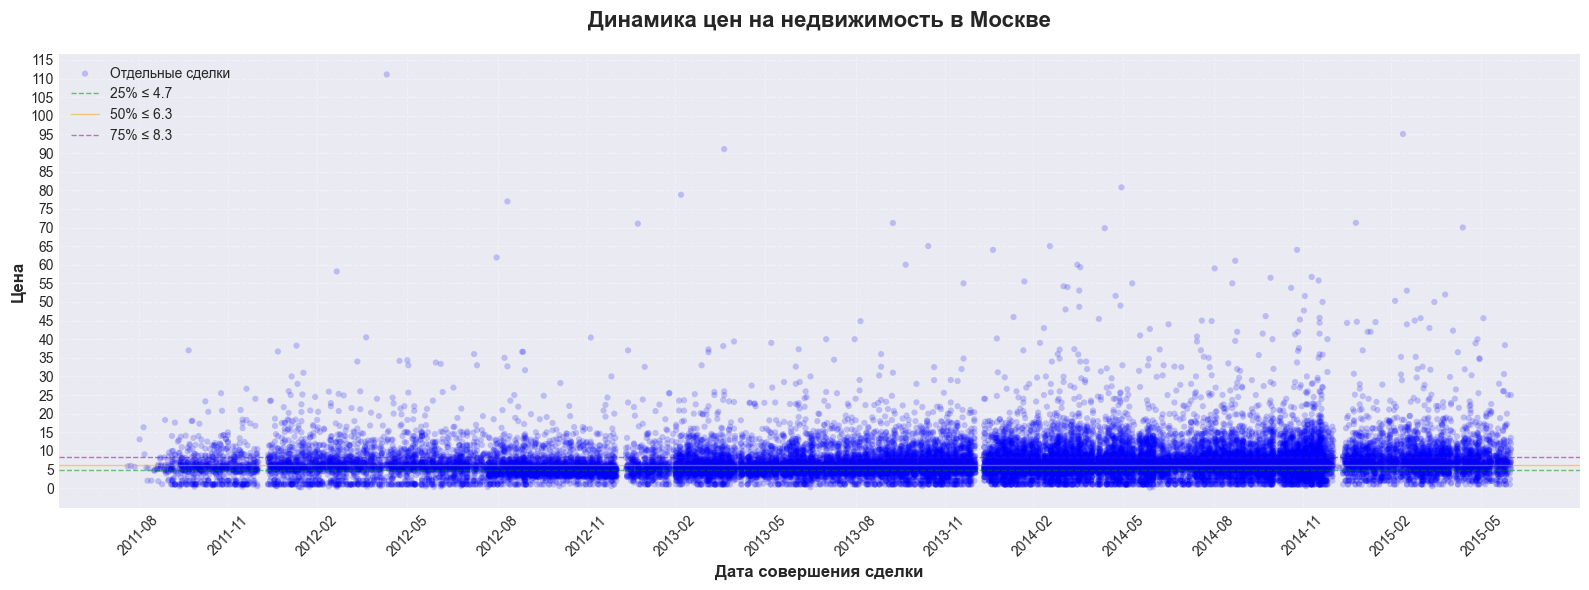

In [10]:
plot_price_dynamics(
    df=train_data,
    date_col="timestamp",
    price_col="price_mln",
    title="Динамика цен на недвижимость в Москве",
)

Теперь посмотрим на распределение плотности цен.

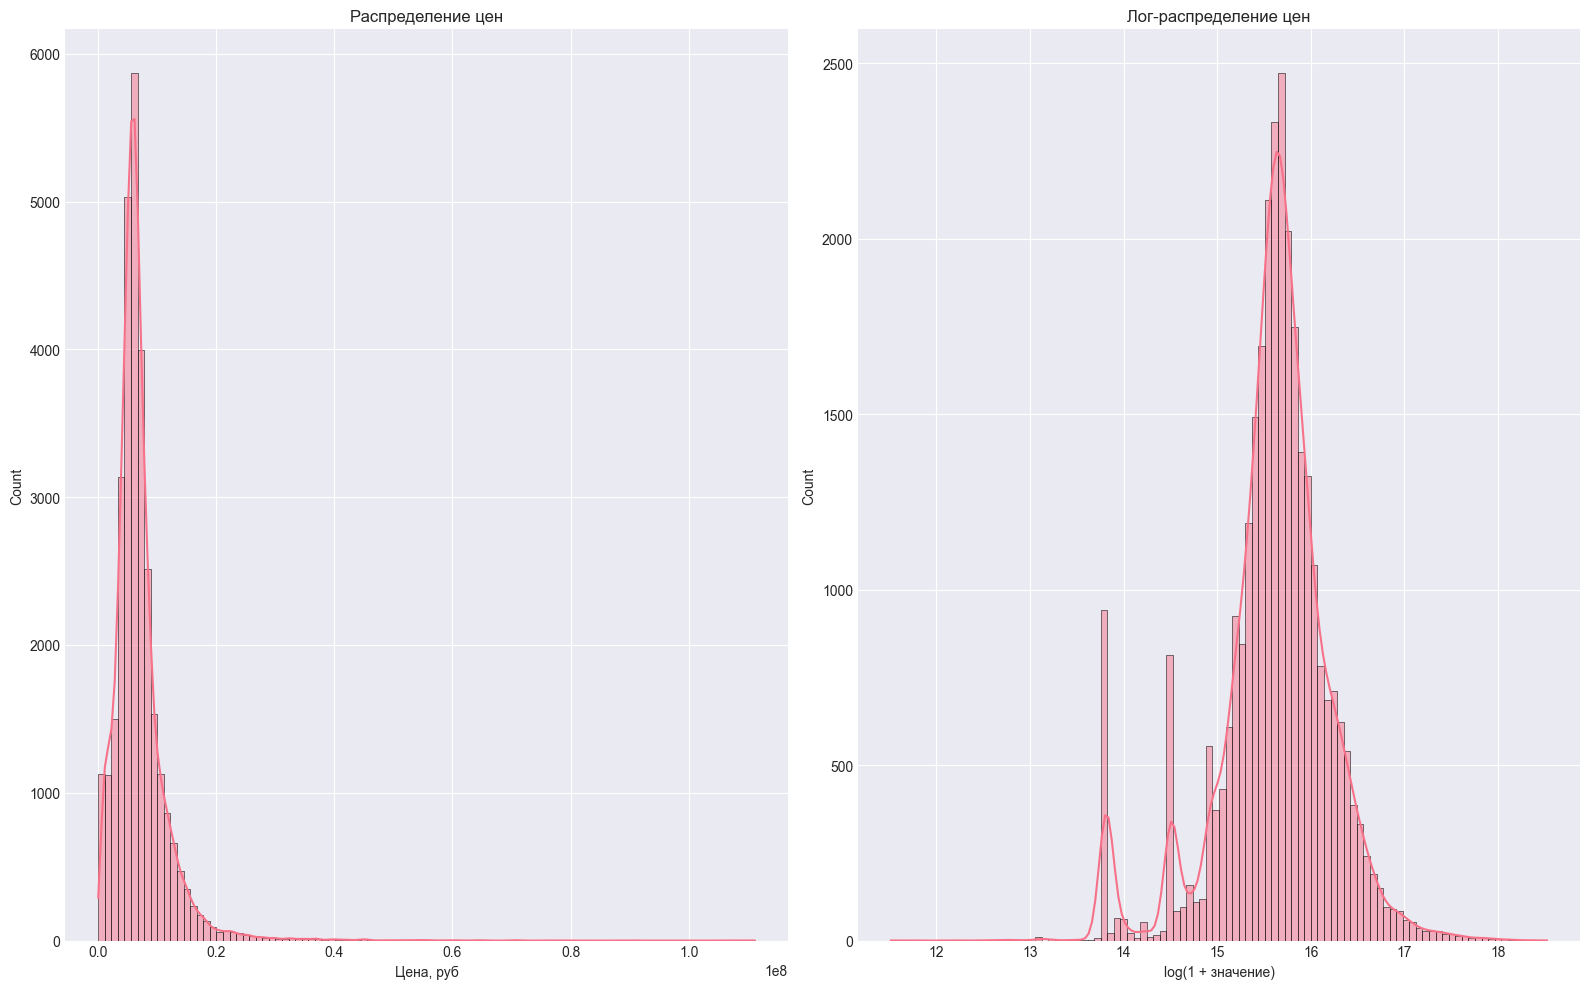

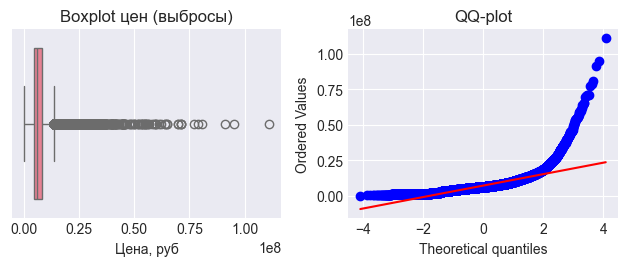

In [11]:
# Гистограмма цен сделок
plot_distribution(
    train_data,
    column='price_doc',
    bins_raw=100,
    bins_log=100,
    xlabel_raw='Цена, руб',
    title_raw='Распределение цен',
    title_log='Лог-распределение цен'
)


# Boxplot
plt.subplot(2, 2, 3)
sns.boxplot(x=train_data['price_doc'])
plt.title('Boxplot цен (выбросы)')
plt.xlabel('Цена, руб')

# QQ-plot
plt.subplot(2, 2, 4)
stats.probplot(train_data['price_doc'], dist="norm", plot=plt)
plt.title('QQ-plot')

plt.tight_layout()
plt.show()

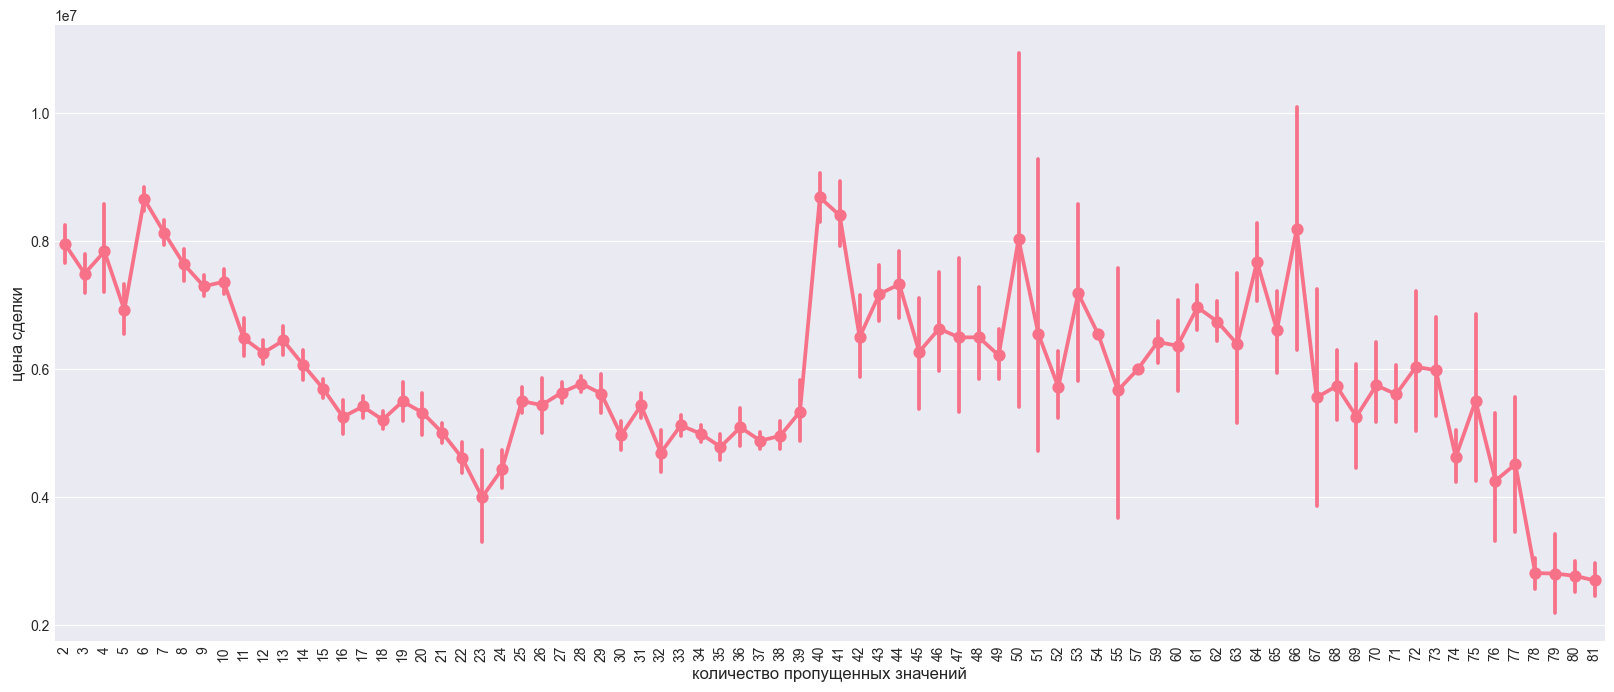

In [12]:
# посмотрим зависимость price_doc от кол. пропущенных значений
train_data['null_count'] = train_data.isnull().sum(axis=1)

# добавляем промежуточный признак
DROP_TEMP_FEATURES.add('null_count')


plt.figure(figsize=(20, 8))
sns.pointplot(x='null_count', y='price_doc', data=train_data)
plt.ylabel('цена сделки', fontsize=12)
plt.xlabel('количество пропущенных значений', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [13]:
print('Линейная взаимосвязь между null_count и price_doc')
train_data[['null_count', 'price_doc']].corr()

Линейная взаимосвязь между null_count и price_doc


,null_count,price_doc
null_count,1.000000,-0.106369
price_doc,-0.106369,1.000000


На графике наблюдается **отрицательная корреляция** – чем больше пропущенных значений, тем меньше цена квартиры.  
_Гипотеза_: дешевые квартиры хуже описаны в БД в отличие от дорогих.

##### Выводы по анализу целевой переменной

- Рынок в 2011–2015 демонстрирует устойчивый рост цен, при этом растёт и разброс цен: появляются как более дорогие, так и более дешёвые сделки — рынок становится более неоднородным.

- Верхний хвост содержит смесь реальных элитных сделок и явных аномалий, нижний хвост тоже включает большое число некорректных записей.

- ```Skewness > 2``` — показывает сильную положительную асимметрию: распределение сильно скошено вправо. QQ-plot и значительная разница между mean и median подтверждают, что данные дальше от нормального распределения, особенно в верхнем хвосте.

- Наблюдается отрицательная корреляция пропущенных значений с целевой переменной, поэтому стоит использовать данный признак во время обучения.


Поскольку наличие выбросов искажает средние, дисперсию и метрики ошибки, из-за чего модель может "подгоняться" под редкие экстремумы и хуже предсказывать целевое значение, то стоит от подобного вида выбросов избавиться.

### Общий анализ признаков

Цели анализа признаков:

1) ```Тип данных```: определить, какие типы данных присутствуют в наборе, чтобы правильно спланировать дальнейшую обработку.
2) ```Категориальные признаки```: оценить уникальные значения и распределение категорий, чтобы выбрать подходящую стратегию кодирования (one-hot, target-encoding и еtс.), и построить кардинальность категориальных признаков;
3) ```Пропущенные значения```: оценить долю и паттерны пропусков по признакам для выбора методов их заполнения или исключения.
4) ```Коллинеарность и корреляция```: проверить линейные зависимости между признаками и целевой переменной, чтобы выявить сильно коррелирующих пар признако.

In [14]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)      
pd.set_option('display.max_colwidth', 50)   
pd.set_option('display.precision', 3)  


# Первые 5 строк тренировочных данных
dprint(
    title="Train data (первые 5 строк)",
    df=train_data.head()
)

# Статистические значения тестовых данных
dprint(
    title="Стат. значения",
    df=test_data.describe()
)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_count_2000,sport_count_2000,mar

#### Тип данных

In [15]:
print('Тип данных')
print(train_data.dtypes)

print("\nЧастота типов данных:")
print(train_data.dtypes.value_counts())

Тип данных
timestamp             datetime64[ns]
full_sq                        int64
life_sq                      float64
floor                        float64
max_floor                    float64
                           ...      
apartment_build              float64
apartment_fund_sqm           float64
year                           int32
price_mln                    float64
null_count                     int64
Length: 391, dtype: object

Частота типов данных:
float64           214
int64             157
object             18
datetime64[ns]      1
int32               1
Name: count, dtype: int64


In [16]:
exclude = ['timestamp', 'price_doc']
categorical_features = find_categorical_features(train_data, max_unique=20, exclude=exclude)

print(f"Явные категориальные (object): {len(categorical_features['object'])}")
print(f"Числовые с <=20 уникальными значениями: {len(categorical_features['numeric'])}")
print()
print(f"Всего категориальных признаков: {len(categorical_features['total'])}")
print(f"Всего не категориальных признаков: {train_data.shape[1] - len(categorical_features['total'])}")

Явные категориальные (object): 18
Числовые с <=20 уникальными значениями: 106

Всего категориальных признаков: 124
Всего не категориальных признаков: 267


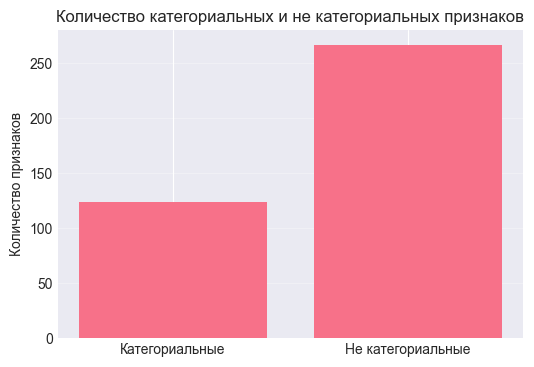

In [17]:
labels = ['Категориальные', 'Не категориальные']
values = [len(categorical_features['total']), train_data.shape[1] - len(categorical_features['total'])]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.title("Количество категориальных и не категориальных признаков")
plt.ylabel("Количество признаков")
plt.grid(axis='y', alpha=0.3)
plt.show()

#### Категориальные признаки

Оценим 18 категориальных признаков с типом object, и постром кардинальность категориальных признаков.

In [18]:
# избавимся от шума в данных, которые во время анализа были найдены 
def normalize_value_obj(series: pd.Series, missing_tokens: dict = None) -> pd.Series:
    """
    Избавимся от всех шумных даннных в категориальных признаков.
    """
    
    if missing_tokens is None:
        missing_tokens = {"no data", "nan", "none", "n/a", "na", "#!", ""}

    s = series.astype(str).str.strip().str.lower()
    s = s.replace(list(missing_tokens), np.nan)
    
    s = s.replace("nan", np.nan)
    return s



def detect_and_summarize_series(
    series: pd.Series,
    normalize: bool = True,
    decimal_comma: bool = True,
    numeric_threshold: float = 0.9,
) -> dict:
    """
    Сводка по серии + определение numeric-like.
    """
    s = series.copy()

    # Базовые метрики
    n_unique = int(s.nunique(dropna=True))
    pct_missing = float(s.isna().mean())
    top_values = s.value_counts(dropna=True).head(5).to_dict()
    is_binary = n_unique <= 2

    # Оценка numeric-like
    tmp = s.dropna().astype(str)
    if tmp.empty:
        is_numeric_like = False
    else:
        if decimal_comma:
            tmp = tmp.str.replace(",", ".", regex=False)
        conv = pd.to_numeric(tmp, errors="coerce")
        success_ratio = float(conv.notna().mean()) if len(conv) > 0 else 0.0
        is_numeric_like = success_ratio >= float(numeric_threshold)

    return {
        "n_unique": n_unique,
        "pct_missing": pct_missing,
        "top_values": top_values,
        "is_binary": is_binary,
        "is_numeric_like": is_numeric_like,
    }


def metric_report_obj_to_df(metric_report: dict) -> pd.DataFrame:
    """
    Преобразует вложенный словарь metric_report в DataFrame.
    """
    records = []
    
    for col, info in metric_report.items():
        rec = {
            "column": col,
            "n_unique": info.get("n_unique"),
            "pct_missing": info.get("pct_missing"),
            "top_values": info.get("top_values", {}),
            "is_binary": info.get("is_binary", False),
            "is_numeric_like": info.get("is_numeric_like", False),
        }
        records.append(rec)
    
    df = pd.DataFrame.from_records(records)
    return df

In [19]:
# нормализуем object-признаки
train_data[categorical_features['object']] = train_data[categorical_features['object']].apply(normalize_value_obj)

# генерируем метрики по obj
metric_report = {col: detect_and_summarize_series(train_data[col]) for col in categorical_features['object']}

# преобразуем в DataFrame для obj / numeric
df_obj_metrics = metric_report_obj_to_df(metric_report)
df_obj_metrics.sample(4)

,column,n_unique,pct_missing,top_values,is_binary,is_numeric_like
7,modern_education_share,3,0.184,"{'93,08': 13662, '90,92': 7978, '95,4918': 3239}",False,True
3,culture_objects_top_25,2,0.000,"{'no': 28543, 'yes': 1928}",True,False
1,big_road1_1line,2,0.000,"{'no': 29690, 'yes': 781}",True,False
16,thermal_power_plant_raion,2,0.000,"{'no': 28817, 'yes': 1654}",True,False


Визуализируем кардинальность категориальных признаков.

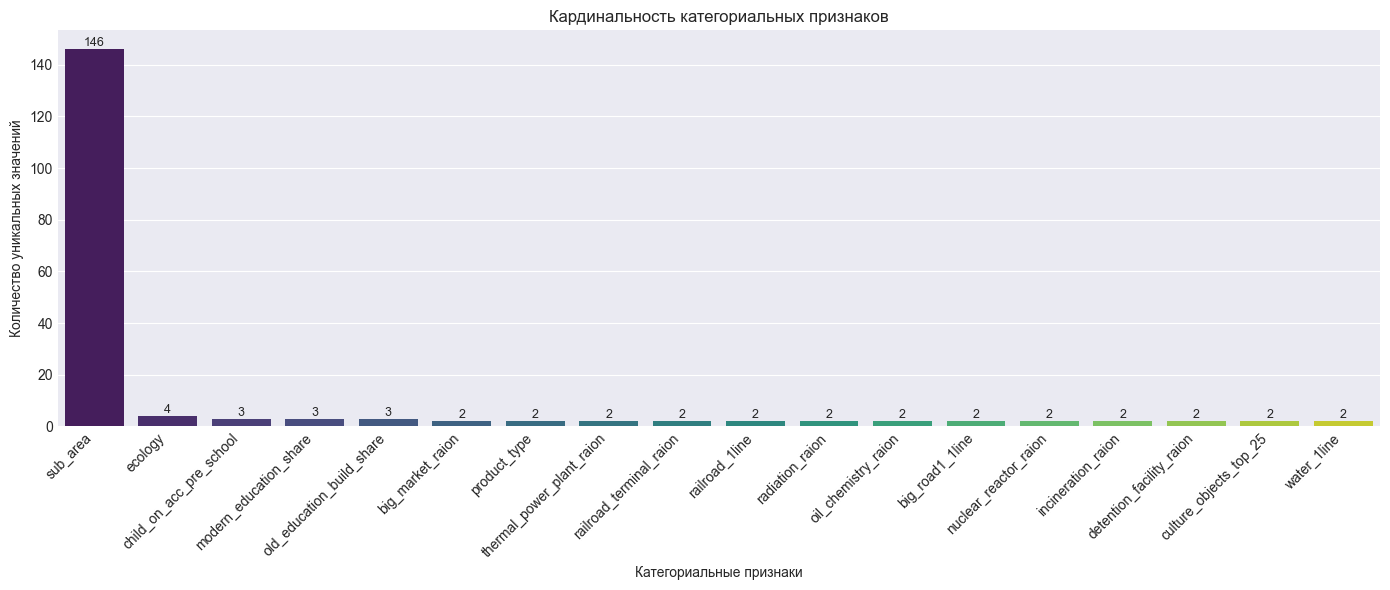

In [20]:
df_obj_sorted = df_obj_metrics.sort_values(by='n_unique', ascending=False)


def barplot_top_unique_values(df: pd.DataFrame, topk: int = 20):
    """Визуализирует топ-k признаков по количеству уникальных значений."""
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(
        x='column',
        y='n_unique',
        data=df.head(topk),
        palette='viridis'
    )
    
    # Добавляем аннотации со значениями на каждый столбец
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f'{height:.0f}',
            (p.get_x() + p.get_width() / 2., height),
            ha='center',
            va='bottom',
            fontsize=9
        )
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Кардинальность категориальных признаков')
    plt.ylabel('Количество уникальных значений')
    plt.xlabel('Категориальные признаки')
    plt.tight_layout()
    plt.show()

barplot_top_unique_values(df_obj_sorted, topk=20)

Категориальный признак типа object с высокой кардинальностью –– sub_area.

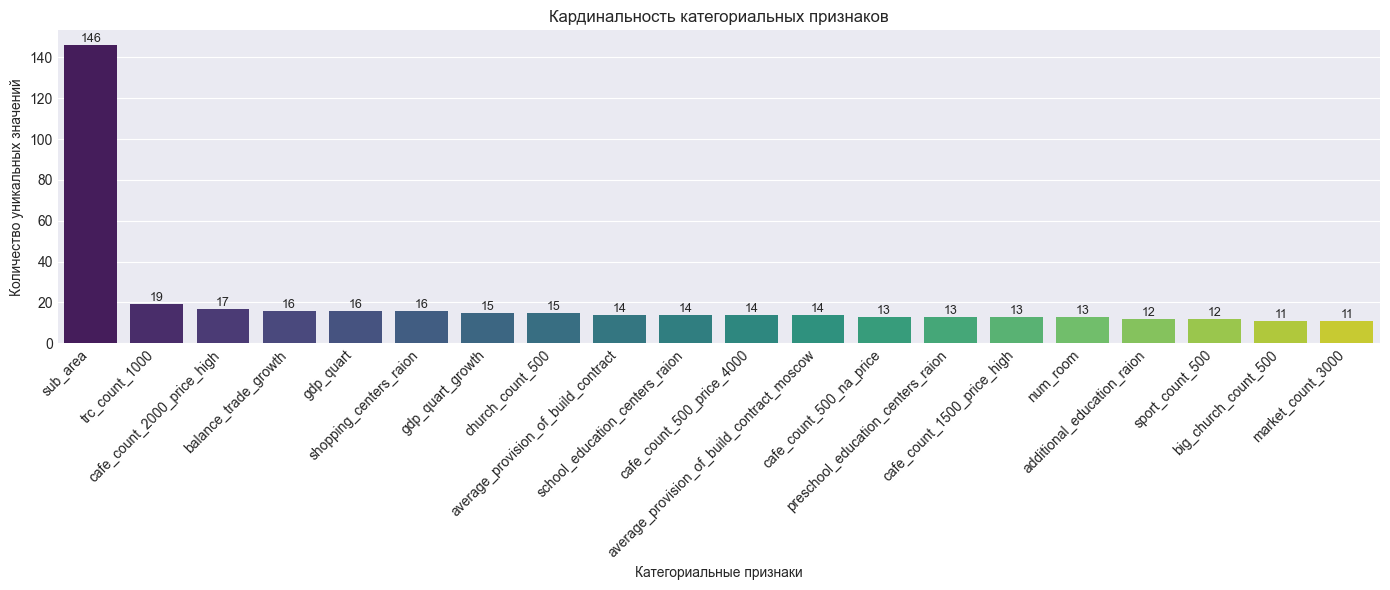

In [21]:
# cписок числовых категориальных признаков
numeric_cat_cols = [
    col for col in train_data.columns 
    if col not in categorical_features['object'] 
    and col != 'timestamp' 
    and col in categorical_features['numeric']
]

numeric_unique_counts = train_data[numeric_cat_cols].nunique().sort_values(
    ascending=False
)
df_unique_counts = numeric_unique_counts.reset_index()
df_unique_counts.columns = ['column', 'n_unique']

df_cats = pd.concat(
    [
        df_unique_counts,
        df_obj_sorted[['column', 'n_unique']]
    ],
    axis=0
).sort_values(by='n_unique', ascending=False)

barplot_top_unique_values(df_cats, topk=20)

Признаки с высокой кардинальностью: 
- sub_area: показывает уникальных районов города;
- trc_count_1000: показывает количество торговых центров в радиусе 1000 метров;
- cafe_count_2000_price_high: показывает количество кафе высокого ценового сегмента в радиусе 2000 метров.

#### Пропущенные значения
Посмотрим на пропущенные значения в признаках

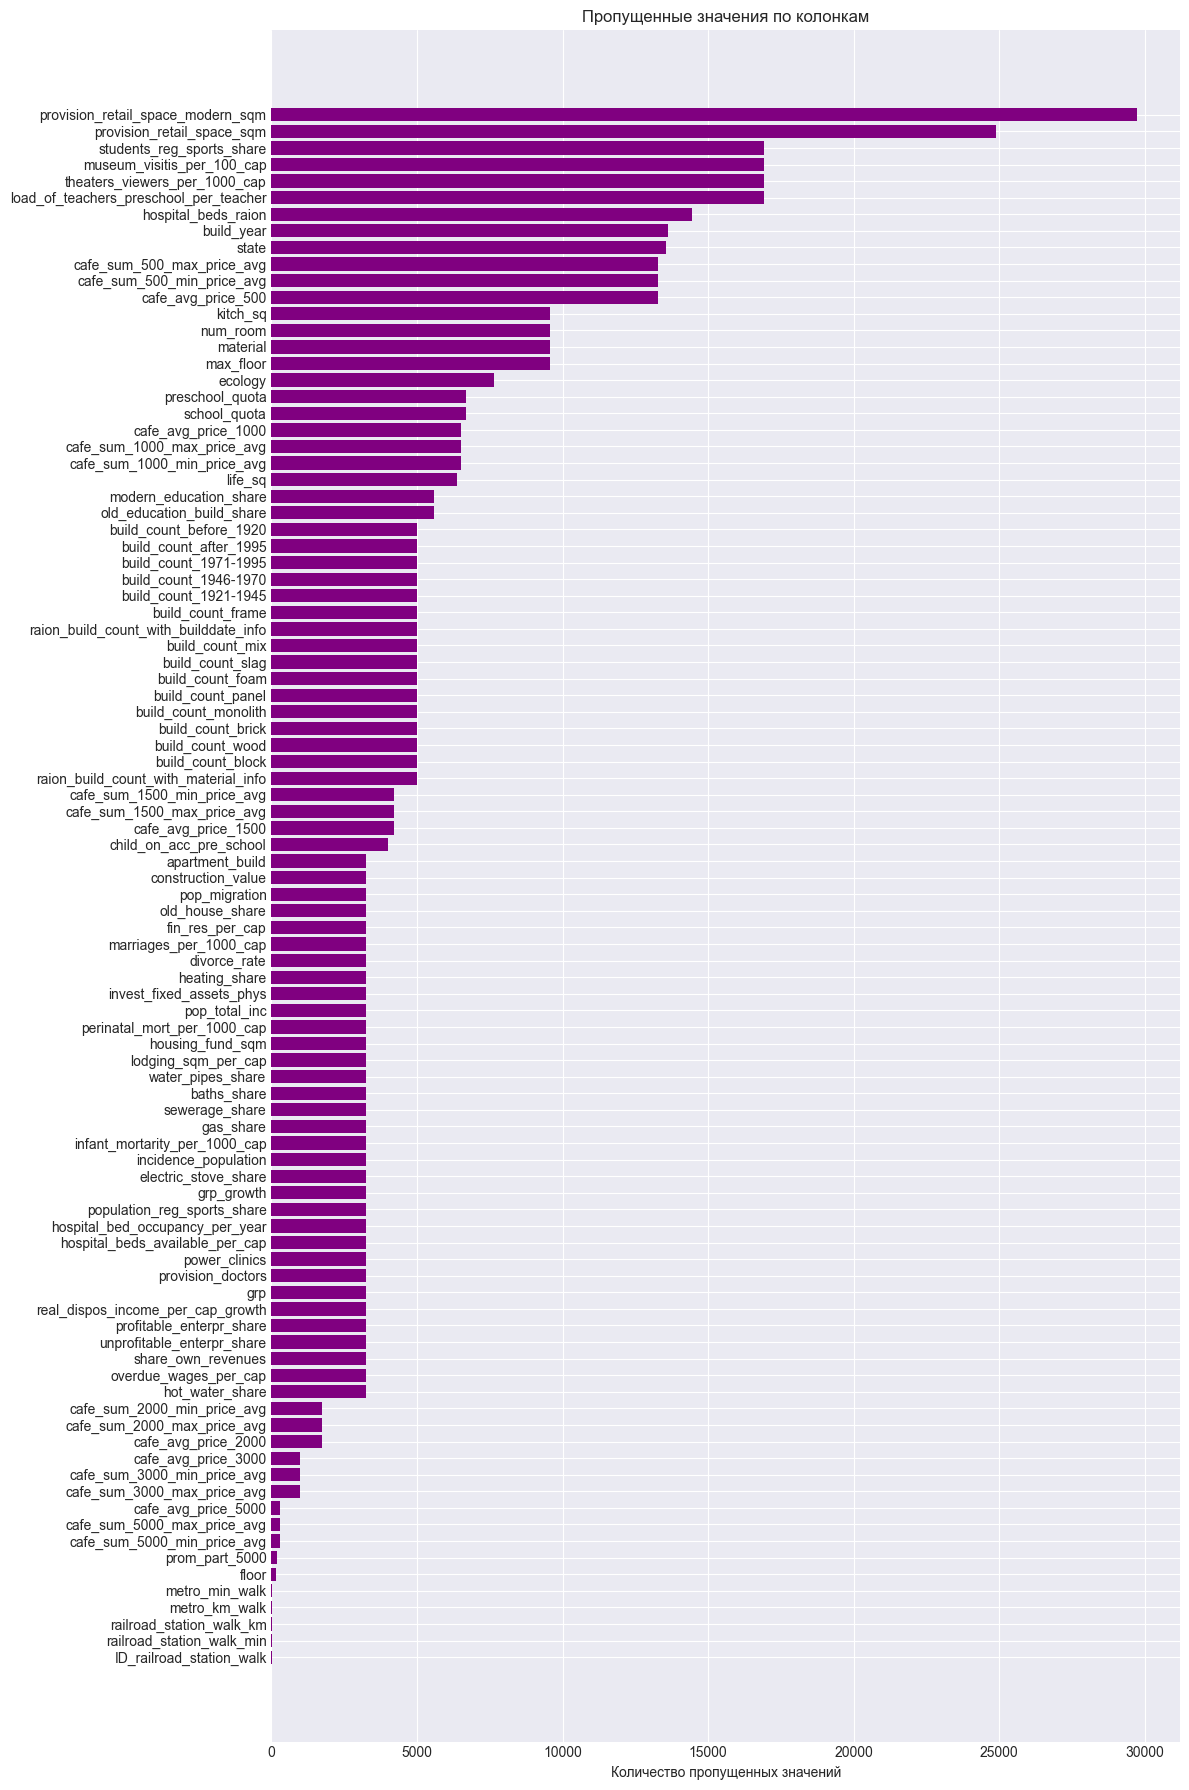

In [22]:
# Подсчёт пропущенных значений
missing_data = (
    train_data.isnull()
    .sum()
    .reset_index()
    .rename(columns={'index': 'column_name', 0: 'missing_count'})
)
missing_data = missing_data[missing_data['missing_count'] > 0] \
    .sort_values(by='missing_count')

# Построение гистограммы
fig, ax = plt.subplots(figsize=(12, 18))
ax.barh(
    missing_data['column_name'],
    missing_data['missing_count'],
    color='purple'
)

ax.set_xlabel('Количество пропущенных значений')
ax.set_title('Пропущенные значения по колонкам')
plt.tight_layout()
plt.show()

In [23]:
# вычисляем долю пропусков
missing_data["ratio"] = (
    missing_data["missing_count"] / len(train_data)
) * 100

# сортируем по убыванию (от max к min)
missing_data = missing_data.sort_values(by="missing_count", ascending=False)

# выбираем топ 20 признака с max(пропущенным значением)
top20_missing = missing_data.head(20)


# визуализируем
dprint(
    'Топ-20 признаков с высокой долей пропущенных значений',
    top20_missing
)

print('Общее количество признаков с пропущенными значениями: ', len(missing_data['column_name'].unique()))

,column_name,missing_count,ratio
378,provision_retail_space_modern_sqm,29718,97.529
377,provision_retail_space_sqm,24879,81.648
385,students_reg_sports_share,16901,55.466
382,museum_visitis_per_100_cap,16901,55.466
380,theaters_viewers_per_1000_cap,16901,55.466
365,load_of_teachers_preschool_per_teacher,16901,55.466
23,hospital_beds_raion,14441,47.393
6,build_year,13605,44.649
9,state,13559,44.498
159,cafe_avg_price_500,13281,43.586


Общее количество признаков с пропущенными значениями:  94


Довольно показательно, что есть признаки, которые практически полностью состоят из пропущенных значений.   
Стоит удалить признаки, которые содержат 50% процентов пропущенных значений, поскольку они неинформативны.

#### Коллинеарность и корреляция

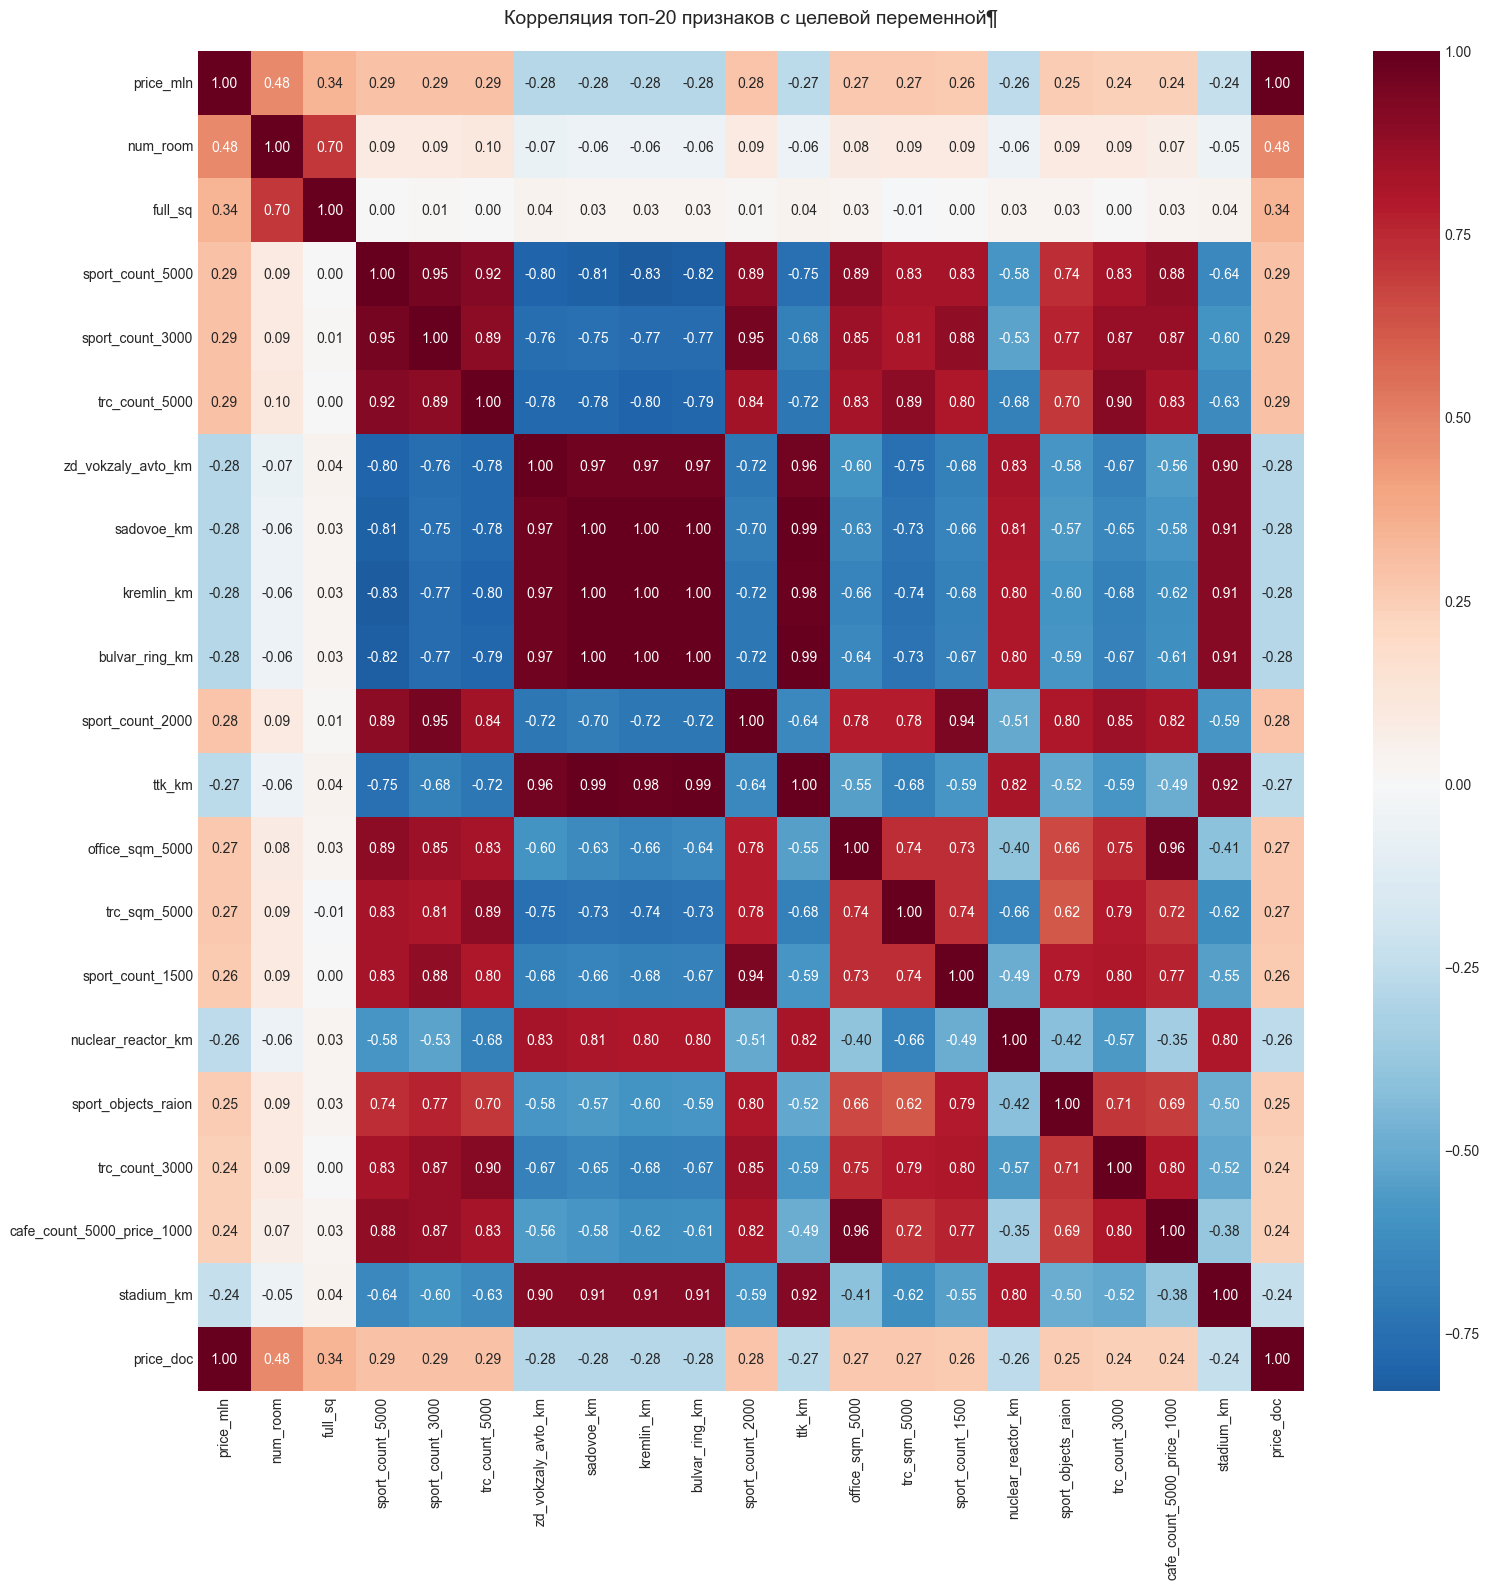

In [24]:
# Посмотрим на топ-20 признаков, наиболее скоррелированных с целевой переменной

plt.figure(figsize=(16, 16))

top_n = 20
numeric_columns = train_data.select_dtypes(include=[np.number, np.float32]).columns
top_features = train_data[numeric_columns].corr()['price_doc'].abs().sort_values(ascending=False).index[1:top_n+1]
corr_matrix = train_data[top_features.tolist() + ['price_doc']].corr()

sns.heatmap(corr_matrix.round(2), annot=True, cmap='RdBu_r', center=0, 
            annot_kws={"size": 10}, fmt='.2f')
plt.title(f'Корреляция топ-{top_n} признаков с целевой переменной¶', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Можно выделить следующие корреляции между признаками:

- num_room и full_sq: существует сильная положительная корреляция, что логично — чем больше площадь квартиры, тем больше вероятность, что в ней будет больше комнат.

- num_room и price_doc: также наблюдается положительная связь, так как квартиры с большим количеством комнат обычно стоят дороже.

- trc_count / sport_count и price_doc: между количеством торговых и спортивных объектов поблизости и ценой квартиры возникает положительная корреляция. Чем больше таких объектов рядом, тем район удобнее для жизни, выше спрос и, соответственно, цена.

- other features(like tadium_km, bulvar_ring_km): эти признаки показывают отрицательную корреляцию с ценой. Чем дальше квартира от стадиона или бульварного кольца, тем ниже престиж района и удобство проживания, что отражается на стоимости жилья.

Попробуем найти мультиколлинеарность между признаками.

In [25]:
# найдем сильно коррелированные признаки

corr_matrix = train_data[numeric_columns].corr().abs()
df_high_corr_pairs = pd.DataFrame(get_high_corr_pairs(corr_matrix))

In [26]:
dprint(
    title="Сильно коррелированные признаки (c целевой переменной)", 
    df=df_high_corr_pairs.query("feature_2 == 'price_doc'").sort_values(['corr'], ascending=False)
)

dprint(
    title="Пара сильно коррелированных признаков", 
    df=df_high_corr_pairs.sort_values(['corr'], ascending=False).head()
)

,feature_1,feature_2,corr
4,num_room,price_doc,0.476
1,full_sq,price_doc,0.342


,feature_1,feature_2,corr
14191,baths_share,old_house_share,1.0
14067,childbirth,baths_share,1.0
14645,provision_retail_space_sqm,apartment_build,1.0
14300,heating_share,old_house_share,1.0
13047,grp,provision_retail_space_sqm,1.0


In [27]:
groups = get_highly_correlated_feature_groups(
    df_high_corr_pairs,
    corr_threshold=0.9
)

print(f'Количество групп признаков с корр. ≥ 0.9: {len(groups)}')

Количество групп признаков с корр. ≥ 0.9: 24


Теперь построим box-plot для признаков num_room и full_sq .

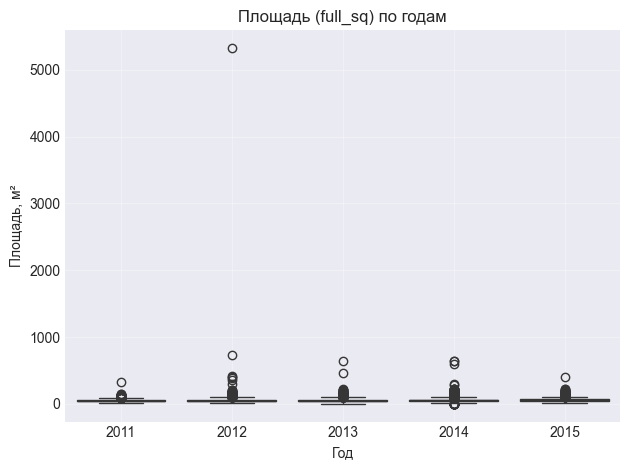

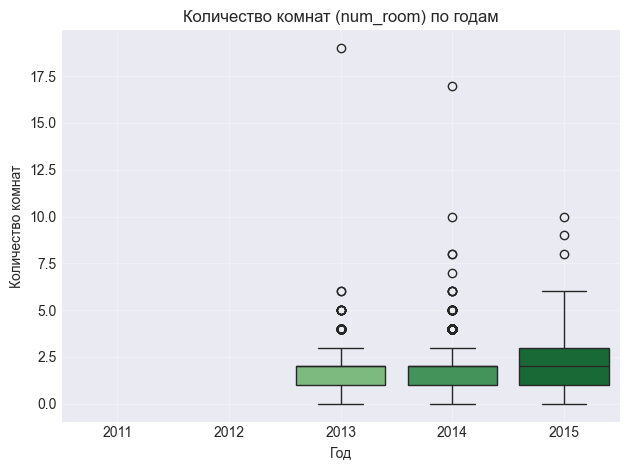

In [29]:
plot_boxplot_by_year(
    train_data,
    y='full_sq',
    title='Площадь (full_sq) по годам',
    ylabel='Площадь, м²',
    palette='Blues'
)

plot_boxplot_by_year(
    train_data,
    y='num_room',
    title='Количество комнат (num_room) по годам',
    ylabel='Количество комнат',
    palette='Greens'
)

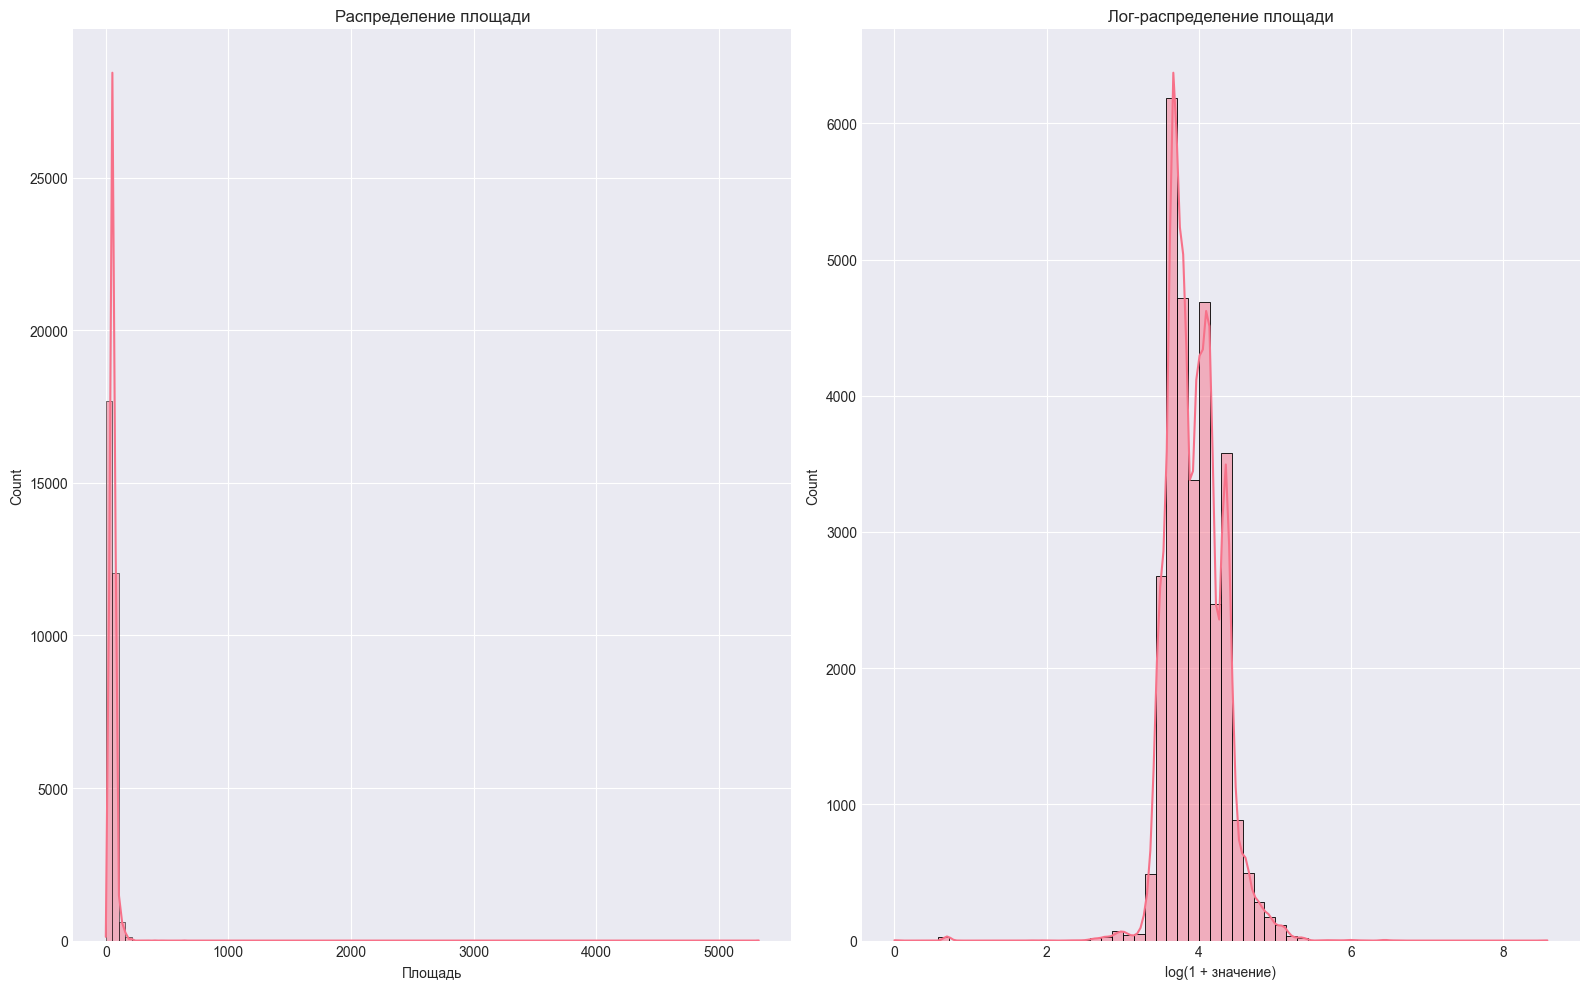

In [30]:
plot_distribution(
    train_data,
    column='full_sq',
    bins_raw=100,
    bins_log=60,
    xlabel_raw='Площадь',
    title_raw='Распределение площади',
    title_log='Лог-распределение площади'
)

Вероятно, в 2011–2012 годах информация о количестве комнат в квартирах не регистрировалась систематически. Тем не менее, можно попробовать восстановить эти значения, используя доступные за весь период наблюдений данные: район (sub_area), этаж (floor), год постройки (build_year) и общую площадь (full_sq).

Также в данных наблюдаются потенциальные аномалии:

- есть квартиры, количество комнат в которых значительно превышает медианное значение;

- встречаются записи, где количество комнат указано как нулевое (num_room == 0).

При этом квартиры с num_room ≤ 20, на мой взгляд, не следует считать выбросами, поскольку в 2016 году в Москве действительно была зафиксирована квартира с 20 комнатами ([источник](https://www.mirkvartir.ru/journal/analytics/2016/08/22/samaa-mnogokomnatnaa-kvartira-v-rossii-sostoit-iz-20-pomesenii/?utm_source=chatgpt.com&utm_referrer=https%3A%2F%2Fchatgpt.com%2F)). Такие значения крайне редки, но реально существуют и не являются аномалией.

Напротив, квартиры с num_room == 0 стоит рассматривать как выбросы или ошибки данных, поскольку жилое помещение без комнат не имеет физического смысла.

#### Выводы по анализу признаков
В данных довольно много пропущенных значений, поэтому стоит проверить корреляцию пропущенных значений с целевой переменной. 
##### **1. Тип данных**
Распределение типов данных:
- Непрерывные числовые (float64): 213 признаков
- Целочисленные (int64): 157 признаков
- Категориальные (object): 18 признаков
- Дата/время (datetime): 1 признак

Категоризация признаков:
- Явные категориальные признаки: 18 (тип object)
- Числовые категориальные признаки: 105 (числовые с ≤20 уникальными значениями)

Таким образом, категориальных признаков и непрерывных числовых составляется 123 и 266, соответственно.


##### **2. Категориальные признаки**
Наглядно видно, что большинство категориальных признаков типа object (за исключением: sub_area, ecology, child_on_acc_pre_school, modern_education_share, big_market_raion) являются бинарными (yes/no).
Это означает, что для них наиболее уместно использовать простое бинарное кодирование, то есть маппинг в формат 0/1.

1) **ecology**: стоит использовать ordinal encoding, поскольку данный признак имеет упорядоченный набор категорий: poor < satisfactory < good < excellent.

2) **sub_area**: Наиболее корректным решением будет использование target encoding в сочетании с out-of-fold, так как данный признак напрямую влияет на стоимость жилья и демонстрирует заметную зависимость от целевой переменной price_doc, которая на промежутке времени меняется (timestamp). То есть важно избежать утечки информации между обучением и валидацией.


3) **child_on_acc_pre_school**, **modern_education_share**, **big_market_raion**: Эти признаки формально числовые, но в данных они представлены как строки с разделителями, поэтому они были классифицированы как категориальные.
После нормализации они превращаются в числовые признаки и могут обрабатываться как numeric, поэтому:
    
- child_on_acc_pre_school — стоит использовать float и масштабировать;
- modern_education_share — также стоит переводить в число;
- old_education_build_share — тоже самое.


##### **3. Пропущенные признаки**
94 из 389 признаков содержат пропущенные значения, из которых наблюдаются с высокой долей пропусков (например, 97.529).
Подобные принаки явяляются неинформативными, поэтому стоит от них избавляться по следующему правилу, например признаки, которые содержать пропущенные значения больше 50% (nan_count > 50%) будут удалены.   

Методы заполнения пропущенных значений:

-  **категориальные признаки**: мода по сегментам (район + тип квартиры + timestamp и тд.);
-  **числовые признаки**: медианное значение по аналогичным объектам.


Также во время анализа целевой переменной стало ясно, что между количеством пропущенных значений и price_dot существует линейно отрицательная взаимосвязь.   
**Гипотеза**: дешевые квартиры имеют менее полное описание в базе данных.   

Можно использовать данный признак в качестве новой фичи + использовать модели, которые имеют встроенную поддержку к nan-значений (CatBoost, LightGBM).

##### **4. Коллинеарность и корреляция**

В ходе анализа было выявлено, что многие признаки имеют высокую взаимную корреляцию. В частности, обнаружено около 390 пар признаков с коэффициентом корреляции ≥ 0.99, что указывает на выраженную мультиколлинеарность. Было выявлено около 24 групп с сильно коррелированными признаками. Наличие такой зависимости может существенно исказить результаты линейных моделей.

Для снижения влияния мультиколлинеарности целесообразно рассмотреть следующие подходы:

- **Агрегация признаков**: объединение сильно скоррелированных переменных в один обобщённый признак или использовать PCA;
- **Использование моделей на основе деревьев решений**: такие алгоритмы менее чувствительны к мультиколлинеарности, поскольку способны учитывать нелинейные зависимости между признаками.

Кроме того, анализ показал, что лишь два признака имеют корреляцию с целевой переменной на уровне ≥ 0.3 — `num_room` и `full_sq`. Это свидетельствует тому, что взаимосвязь большинства признаков с целевым показателем носит нелинейный характер. В связи с этим для решения задачи целесообразно использовать модели, способные выявлять нелинейные зависимости, в частности градиентный бустинг.

## Model

### LightAutoML (LAMA)

Часто используемые методы во время моделирования моделей.

In [ ]:
# Логирование
def setup_logger(name='Sberbank_Russian_Housing_Market'):
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    if not logger.handlers:
        handler = logging.StreamHandler(sys.stdout)
        formatter = logging.Formatter(
            '%(asctime)s - %(levelname)s - %(message)s'
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    return logger


def rmsle_score(y_true, y_pred):
    """
    Вычисляет метрику RMSLE (Root Mean Squared Logarithmic Error).
    """
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)

    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)

    return np.sqrt(np.mean((log_pred - log_true)**2))


def prepare_data(
    data: tuple[pd.DataFrame, pd.DataFrame],
    preprocessor,
    target_col: str = 'price_doc',
    timestamp_col: str = 'timestamp',
    val_fraction: float = 0.2
):
    """
    Применяет препроцессор к данным, удаляет лишние колонки,
    и делает time-based split на train/validation.
    
    Возвращает (X_train, X_test, y_train, y_test), test
    """
    
    train, test = data
    tr_data = preprocessor.fit_transform(train, train[target_col])
    te_data = preprocessor.transform(test)

    # Удаляем категориальный признак sub_area после кодирования
    tr_data = tr_data.drop(columns=['sub_area'])
    te_data = te_data.drop(columns=['sub_area'])

    # Time split
    split_date = tr_data[timestamp_col].quantile(1 - val_fraction)
    tr_data_split = tr_data[tr_data[timestamp_col] <= split_date].copy()
    val_data_split = tr_data[tr_data[timestamp_col] > split_date].copy()

    te_data = te_data.drop(columns=[timestamp_col])

    X_train = tr_data_split.drop(columns=[target_col, timestamp_col])
    X_test = val_data_split.drop(columns=[target_col, timestamp_col])
    y_train = tr_data_split[target_col]
    y_test = val_data_split[target_col]

    return (X_train, X_test, y_train, y_test), te_data

logger = setup_logger()

In [8]:
DATA_DIR = Path("./data/raw")

DROP_COLS = [
    "ID_bus_terminal",
    "ID_railroad_terminal"
]

train_dataset, test_dataset = load_and_prepare_data(
    data_dir=DATA_DIR,
    drop_columns=DROP_COLS
)

Train shape: (30471, 389)
Test shape: (7662, 388)


In [9]:
# определим роли признаков, все признаки, которые будут иметь уникальных 
# значений меньше 20 будут считаться категориальным
exclude = ['timestamp', 'price_doc']
categorical_features = find_categorical_features(
    train_dataset, max_unique=20, exclude=exclude
)

binary_cols = [
    x for x in categorical_features['object'] + ['sub_area_te', 'ecology_ord']
    if x not in ['sub_area', 'ecology']
]

numeric_cols = [
    'child_on_acc_pre_school', 
    'modern_education_share', 
    'old_education_build_share'
]

#### Configs

Относительно параметра switch будем менять параметры конфигурации.   
Для обоих конфигураций будем использовать 20% train данных на теcтирование, а всё остальное на обучение. Также учитывается временной порядок данных (timestamp), чтобы избежать утечки информации из будущего в прошлое.


**Стратегия 1 (switch=False) — стандартная**  

- timeout: 1 час
- general_params: None — на протяжении часа будут использоваться все доступные алгоритмы LightAutoML по умолчанию.

**Стратегия 2 (switch=True)- ускоренный стекинг с преднастроенными моделями**  
- timeout: 30 минут 
- general_params: [['linear_l2', 'lgb', 'cb'],['lgb_tuned', 'cb_tuned']] - используется двухуровневый стекинг. Cначала обучаются базовые модели (linear_l2, lgb, cb), а затем усиливаются тюнингованными версиями LightGBM и CatBoost (lgb_tuned, cb_tuned).

In [ ]:
def run_lama_baseline(
    name: str,
    data: tuple[pd.DataFrame, pd.DataFrame],
    categorical_features: list, 
    val_fraction: float = 0.2,
    random_state=22,
    switch: bool = False
):
    """
    Запуск baseline-модели LightAutoML (LAMA) для задачи регрессии
    с временной зависимостью данных.

    Функция выполняет time-based разбиение данных по колонке `timestamp`,
    обучает модель `TabularAutoML` с метрикой RMSLE и оценивает качество
    на валидационной выборке.

    Поддерживаются два режима работы:
    - базовый режим (`switch=False`) с ограниченным набором алгоритмов;
    - расширенный режим (`switch=True`) с тюнингованными моделями
      LightGBM и CatBoost и увеличенным временем обучения.
    """

    logger.info("="*60)
    logger.info(f"Starting LAMA baseline: {name}")
    logger.info("="*60)


    train, _ = data
    train = train.sort_values("timestamp")
    
    split_date = train["timestamp"].quantile(1 - val_fraction)
    tr_data = train[train["timestamp"] <= split_date]
    te_data = train[train["timestamp"] > split_date]


    # задаем задачу
    task = Task(name="reg", greater_is_better=False, metric="rmsle", loss="rmsle")

    # для 2-го конфига
    general_params = {
        "use_algos": [
            ['linear_l2', 'lgb', 'cb'],         
            ['lgb_tuned', 'cb_tuned']       
        ]
    }
    
    # указываем роли
    roles = {
        "target": 'price_doc',
        "drop": ['ID_bus_terminal', 'ID_railroad_terminal', 'id'],
        "category": categorical_features,
        DatetimeRole(
            seasonality=('d', 'm', 'wd'),
            base_date=True
        ): 'timestamp'
    }
    
    ts_cv = TimeSeriesIterator(
        datetime_col=tr_data['timestamp'],
        n_splits=3
    )

    # настраиваем гиперпараметры AutoML
    automl = TabularAutoML(
        task=task,
        timeout=3600 if switch else 1800,
        cpu_limit=4,
        gpu_ids='0,1,2,3',
        general_params=general_params if switch else None,
        reader_params={'random_state': 22, 'n_jobs': 4} if switch else {'random_state': 22}
    )
    # запускаем AutoML
    oof_pred = automl.fit_predict(
        tr_data, 
        roles=roles, 
        cv_iter=ts_cv, 
        verbose=1
    )

    test_pred = automl.predict(te_data)
    rmsle_score_value = rmsle_score(te_data['price_doc'].values, test_pred.data[:, 0])

    return {
        'name': name,
        'rmsle_score': rmsle_score_value
    }

In [ ]:
results_standard = run_lama_baseline(
    name="LightAutoML_Standard",
    data=(train_dataset, test_dataset),
    categorical_features=categorical_features
)

2025-12-20 16:43:16,785 - INFO - ============================================================
2025-12-20 16:43:16,785 - INFO - Starting LAMA baseline: LightAutoML_Standard
2025-12-20 16:43:16,785 - INFO - ============================================================
[16:43:16] Stdout logging level is INFO.
[16:43:16] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[16:43:16] Task: reg

[16:43:16] Start automl preset with listed constraints:
[16:43:16] - time: 1800.00 seconds
[16:43:16] - CPU: 4 cores
[16:43:16] - memory: 16 GB

[16:43:16] Train data shape: (24390, 389)

[16:43:22] Layer 1 train process start. Time left 1794.22 secs
[16:43:24] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


In [ ]:
results_standard

{'name': 'LightAutoML_Standard', 'rmsle_score': 0.4263306185475109}

In [ ]:
results_stacking = run_lama_baseline(
    name="LightAutoML_Stacking",
    data=(train_dataset, test_dataset),
    categorical_features=categorical_features,
    switch=True
)

In [ ]:
results_stacking

{'name': 'LightAutoML_Stacking', 'rmsle_score': 0.4202060739876445}

#### Результаты двух конфигураций
**Config 1:**

- timeout=3600
- use LightAutoML's algorithms (all)
- OOF RMSLE: 0.4263

**Config 2:**

- timeout=1800
- use LightAutoML's algorithms [['linear_l2', 'lgb', 'cb'],['lgb_tuned', 'cb_tuned']]
- OOF RMSLE: 0.4202

**Вывод:** Наилучший результат показала вторая конфигурация. В дальнейшем мы будем опираться именно на неё и стремиться разработать решение, которое превзойдёт текущий показатель качества — ```0.4202```.

###  Собственное решение (Manual)

#### Feature Engineering
Генерация новых признаков:

- **living_area_ratio:** отношение жилой площади к общей площади квартиры   
  Смысл: показывает, сколько реально жилой площади приходится на квартиру относительно всего помещения. Низкое значение может означать большую часть площади, занятую подсобными или нежилыми помещениями, что может снижать стоимость.

- **floor_ratio:** доля этажа относительно максимального этажа в доме   
  Смысл: отражает расположение квартиры внутри дома. Квартиры на верхних этажах часто дороже из-за вида и меньшего шума, а на нижних – дешевле. Нормализованное значение помогает учесть разные дома с разной этажностью.

- **rooms_per_total_sq:** отношение количества комнат к полной площади (num_room / full_sq)   
  Смысл: показывает плотность планировки — много комнат на маленькой площади может указывать на маленькие комнаты, что может снижать привлекательность квартиры.


- **amenities_per_1k_pop:** количество ключевых объектов инфраструктуры (кафе, торговые центры, офисы, спортивные объекты) на 1000 жителей района
  Смысл: оценивает плотность инфраструктуры в районе в радиусе 500 метров. Чем больше объектов на душу населения, тем выше удобство проживания, а значит и стоимость квартиры может быть выше.

In [ ]:
class NewFeatures(BaseEstimator, TransformerMixin):
    """
    Класс для генерации признаков, связанных с количеством комнат, жилой площадью,
    этажностью и инфраструктурой.
    """
    def __init__(self, amenities_cols=None, pop_col='raion_popul'):
        
        if amenities_cols is None:
            self.amenities_cols = ['cafe_count_500', 'trc_count_500', 'office_count_500', 'sport_count_500']
        else:
            self.amenities_cols = amenities_cols
        self.pop_col = pop_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # living_area_ratio
        X['living_area_ratio'] = X['life_sq'] / X['full_sq']
        
        # floor_ratio
        X['floor_ratio'] = X['floor'] / X['max_floor']
        
        # rooms_per_total_sq
        X['rooms_per_total_sq'] = X['num_room'] / X['full_sq']

        amenities_cols = [
            'cafe_count_500', 'trc_count_500', 'office_count_500', 'sport_count_500'
        ]
                
        # amenities_per_1k_pop
        X['amenities_per_1k_pop'] = X[self.amenities_cols].sum(axis=1) / X[self.pop_col] * 1000
        
        return X

#### Feature Preprocessing


Сформируем улучшения, которые удалось выявить во время EDA:

1) избавимся от неинформативных признаков, которые содержат >= 50% пропущенных значений;
2) преобразуем категориальные признаки учитывая их специфику, но предварительно заполним пропущенные знач;
3) уменьшим количество признаков, используя PCA для того, чтобы уменшить размер данных (касается сильно коррелированных между собой признаков > 0.9).

##### 1. Удаление неинформативных признаков

In [ ]:
class MissingFeatureRemover(BaseEstimator, TransformerMixin):
    """
    Удаляет признаки, у которых доля пропусков >= threshold.
    """

    def __init__(
        self,
        threshold: float = 0.5,
        exclude: Optional[List[str]] = None,
    ):
        self.threshold = threshold
        self.exclude = exclude if exclude is not None else []
        self.drop_cols_: Optional[List[str]] = None

    def fit(self, X: pd.DataFrame, y=None):
        X = X.copy()

        miss_ratio = X.isna().mean()
        drop_cols = miss_ratio[miss_ratio >= self.threshold].index.tolist()

        self.drop_cols_ = [
            col for col in drop_cols
            if col not in self.exclude
        ]

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.drop_cols_ is None:
            raise RuntimeError("Трансформер не обучен. Сначала вызовите fit().")

        X = X.copy()

        # Удаляем только те колонки, которые реально есть в данных
        cols_to_drop = [c for c in self.drop_cols_ if c in X.columns]
        X = X.drop(columns=cols_to_drop)

        return X

##### 2. Кодируем признаки учитывая их специфику

In [ ]:
BINARY_MAPPING: Dict[str, int] = {
    "no": 0,
    "yes": 1,
    "owneroccupier": 0,
    "investment": 1,
}


class BinaryEncoder(BaseEstimator, TransformerMixin):
    """Бинарное кодирование для признаков типа yes/no или owner/investment."""

    def __init__(
        self,
        cols: Optional[List[str]] = None,
        exclude: Optional[List[str]] = None,
        mapping: Optional[Dict[str, int]] = None,
    ):
        self.cols = cols or []
        self.exclude = exclude or []
        self.mapping = mapping or BINARY_MAPPING

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        for col in self.cols:
            if col in self.exclude:
                continue

            if col not in X.columns:
                logger.info("BinaryEncoder: колонка '%s' не найдена — пропущено", col)
                continue

            X[col] = (
                X[col]
                .astype(str)
                .str.strip()
                .str.lower()
                .map(self.mapping)
            )
            X[col] = X[col].astype("Int64")

        return X


class SklearnTargetEncoder(BaseEstimator, TransformerMixin):
    """
    Обёртка над category_encoders.TargetEncoder.
    Безопасна, если на transform некоторые cols отсутствуют.
    """

    def __init__(self, cols: Optional[List[str]] = None, smoothing: int = 10):
        self.cols = cols or ["sub_area"]
        self.smoothing = smoothing
        self.target_encoder = ce.TargetEncoder(cols=self.cols, smoothing=self.smoothing)
        self.fitted_cols_ = []

    def fit(self, X: pd.DataFrame, y=None):
        # берем только те колонки, которые есть в X
        fit_cols = [c for c in self.cols if c in X.columns]
        if not fit_cols:
            logger.info("SklearnTargetEncoder.fit: нет колонок для обучения TargetEncoder.")
            return self

        self.fitted_cols_ = fit_cols
        self.target_encoder = ce.TargetEncoder(cols=self.fitted_cols_, smoothing=self.smoothing)
        self.target_encoder.fit(X[self.fitted_cols_], y)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        present_cols = [c for c in self.fitted_cols_ if c in X.columns]
        if not present_cols:
            logger.info("SklearnTargetEncoder.transform: нет обученных колонок в X — пропускаем.")
            return X

        te_df = self.target_encoder.transform(X[present_cols])
        for col in present_cols:
            X[f"{col}_te"] = te_df[col]

        return X


class OrdEncoder(BaseEstimator, TransformerMixin):
    """Порядковое кодирование для категориальных признаков с упорядоченной шкалой (например, ecology)."""

    def __init__(self, cols: Optional[List[str]] = None):
        self.cols = cols or ["ecology"]
        self.ord_encoder = OrdinalEncoder(
            categories=[["poor", "satisfactory", "good", "excellent"]],
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            dtype=np.int32,
        )

    def fit(self, X: pd.DataFrame, y=None):
        self.ord_encoder.fit(X[self.cols])
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        encoded = self.ord_encoder.transform(X[self.cols])
        for i, col in enumerate(self.cols):
            X[f"{col}_ord"] = encoded[:, i]

        X.drop(columns=self.cols, inplace=True, errors="ignore")
        return X


class StringNumericConverter(BaseEstimator, TransformerMixin):
    """Конвертация строковых чисел типа '1,234' в числовой формат float."""

    def __init__(self, cols: Optional[List[str]] = None):
        self.cols = cols or []

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        for col in self.cols:
            if col not in X.columns:
                logger.info(
                    "StringNumericConverter: колонка '%s' не найдена — пропущено", col
                )
                continue

            X[col] = X[col].astype(str).str.replace(",", ".", regex=False).str.strip()
            X[col] = pd.to_numeric(X[col], errors="coerce")

        return X


class Scaler(BaseEstimator, TransformerMixin):
    """
    Обёртка над sklearn.StandardScaler, возвращает DataFrame
    с сохранением названий колонок и индексов.
    Устойчива к отсутствию колонок в transform.
    """

    def __init__(self, cols: Optional[List[str]] = None):
        self.cols = cols or []
        self.scaler = StandardScaler()
        self.cols_ = []  # реальные колонки, использованные при fit

    def fit(self, X: pd.DataFrame, y=None):
        self.cols_ = [c for c in self.cols if c in X.columns]
        if not self.cols_:
            logger.info("Scaler.fit: нет колонок для масштабирования.")
            return self

        self.scaler.fit(X[self.cols_])
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        if not self.cols_:
            return X

        present_cols = [c for c in self.cols_ if c in X.columns]
        missing_cols = [c for c in self.cols_ if c not in X.columns]

        if missing_cols:
            logger.info("Scaler.transform: пропущены колонки %s — пропускаем их", missing_cols)

        if not present_cols:
            return X

        X_scaled = self.scaler.transform(X[present_cols])
        X[present_cols] = pd.DataFrame(X_scaled, columns=present_cols, index=X.index)
        return X



class GroupImputer(BaseEstimator, TransformerMixin):
    """
    Заполняет пропущенные значения медианой внутри группы.
    Если медиана группы отсутствует, используется глобальная медиана.
    Только пропущенные значения заменяются, остальные остаются без изменений.
    """
    def __init__(self, cols: list | str = '*', group_cols: list = ['year', 'sub_area'], ts_col: str = 'timestamp'):
        self.cols = cols
        self.group_cols = group_cols
        self.ts_col = ts_col
        self.group_medians = None
        self.global_medians = None
        self._temp_year_created = False
        self.selected_cols = None

    def fit(self, X: pd.DataFrame, y=None):
        X = X.copy()

        # Создаем year, если его нет
        if 'year' in self.group_cols and 'year' not in X.columns:
            X['year'] = pd.to_datetime(X[self.ts_col]).dt.year
            self._temp_year_created = True

        # Выбираем колонки для заполнения
        if self.cols == '*':
            self.selected_cols = X.select_dtypes(include=['number']).columns.tolist()
        else:
            self.selected_cols = [c for c in self.cols if c in X.columns]

        # Медианы
        self.group_medians = X.groupby(self.group_cols)[self.selected_cols].median()
        self.global_medians = X[self.selected_cols].median()

        # Убираем временный признак
        if self._temp_year_created:
            X.drop(columns=['year'], inplace=True)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        # Создаем year, если его нет
        if self._temp_year_created and 'year' not in X.columns:
            X['year'] = pd.to_datetime(X[self.ts_col]).dt.year

        # Берем только колонки с пропусками
        cols_to_fill = [c for c in self.selected_cols if c in X.columns and X[c].isna().any()]

        for col in tqdm(cols_to_fill, desc='Заполняем пропущенные значения'):
            if col not in X.columns:
                continue

            # Маска пропущенных значений
            mask = X[col].isna()

            # Заполняем только пропущенные значения медианой группы
            X.loc[mask, col] = (
                X[mask].groupby(self.group_cols)[col]
                .transform(lambda g: g.fillna(g.median()))
            )

            # Если остались NaN (например, группа была полностью пустая) — используем глобальную медиану
            X[col] = X[col].fillna(self.global_medians[col])

        # Убираем временный признак
        if self._temp_year_created:
            X.drop(columns=['year'], inplace=True)

        return X

##### 3. Уменьшаем размерность данных на основе сильно скоррелированных признаков

In [ ]:
class CorrelatedGroup(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        corr_threshold: float = 0.9,
        n_components: int = 1,
        prefix: str = "pca_grp",
        scale: bool = True,
        min_explained_variance: float = 0.6,
    ):
        self.corr_threshold = corr_threshold
        self.n_components = n_components
        self.prefix = prefix
        self.scale = scale
        self.min_explained_variance = min_explained_variance

    def fit(self, X: pd.DataFrame, y=None):
        X = X.select_dtypes(include=[np.number]).copy()

        self.pca_models_ = {}
        self.scalers_ = {}
        self.group_features_ = {}
        self.used_features_ = set()

        if X.shape[1] < 2:
            return self

        corr = X.corr().abs()
        mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

        rows, cols = np.where((corr.values >= self.corr_threshold) & mask)

        G = nx.Graph()
        for i, j in zip(rows, cols):
            G.add_edge(corr.columns[i], corr.columns[j])

        groups = [list(g) for g in nx.connected_components(G) if len(g) > 1]

        for idx, group in enumerate(groups):
            Xg = X[group].fillna(0)

            if self.scale:
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(Xg)
                self.scalers_[idx] = scaler
            else:
                X_scaled = Xg.values

            pca = PCA(n_components=self.n_components, random_state=42)
            pca.fit(X_scaled)

            if pca.explained_variance_ratio_[0] < self.min_explained_variance:
                continue

            self.pca_models_[idx] = pca
            self.group_features_[idx] = group
            self.used_features_.update(group)

        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()

        for idx, pca in self.pca_models_.items():
            group = [c for c in self.group_features_[idx] if c in X.columns]
            if len(group) < 2:
                continue

            Xg = X[group].fillna(0)

            if self.scale:
                X_scaled = self.scalers_[idx].transform(Xg)
            else:
                X_scaled = Xg.values

            X[f"{self.prefix}_{idx}"] = pca.transform(X_scaled)[:, 0]

        X.drop(columns=[c for c in self.used_features_ if c in X.columns], inplace=True)
        return X

#### Решение 1

Будем использовать Stacking Regressor, который будет объединять три модели:

- Линейная модель (ElasticNet) — для захвата линейных зависимостей в данных.
- XGBoost — градиентный бустинг на деревьях, хорошо работает с нелинейными признаками.
- LightGBM — быстрый градиентный бустинг, дополняющий XGBoost.

В качестве финального оценщика используется Ridge, который обучается на предсказаниях трёх базовых моделей.

Для таргета применим логарифмическая трансформация (log1p) для стабилизации дисперсии и снижения влияния больших значений. Предварительно обработаем данные с помощью кастомного pipeline:

- MissingFeatureRemover: избавит от неинформировных признаков;
- StringNumericConverter: обработает категориальные признаки;
- GroupImputer: заполнит пропущенные значения учитывая 'year' и 'sub_area';
- Scaler: стандартизирует данные;
- SklearnTargetEncoder + OrdEncoder + BinaryEncoder: преобразует категориальные признаки.
- CorrelatedGroup: группирует сильно коррелированные признаки (сorr > 0.9) и применяет PCA к каждой группе для уменьшения размерности».

In [ ]:
preprocessor = Pipeline([
    ('rm', MissingFeatureRemover(threshold=0.5)),
    ('str_num', StringNumericConverter(cols=numeric_cols)),
    ('impute', GroupImputer(cols="*", group_cols=['year', 'sub_area'])),
    ('scale', Scaler(cols=numeric_cols)),
    ('te', SklearnTargetEncoder(cols=['sub_area'])),
    ('ord', OrdEncoder(cols=['ecology'])),
    ('binary', BinaryEncoder(
        cols=categorical_features['object'],
        exclude=numeric_cols,
        mapping=BINARY_MAPPING
    )),
    ('pca', CorrelatedGroup(corr_threshold=0.9))
])

In [ ]:
train_prep, test_prep = prepare_data((train_dataset, test_dataset), preprocessor)

Заполняем пропущенные значения: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 14.94it/s]


2025-12-20 11:56:56,138 - INFO - BinaryEncoder: колонка 'ecology' не найдена — пропущено


Заполняем пропущенные значения: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:04<00:00, 22.61it/s]


2025-12-20 11:57:08,845 - INFO - BinaryEncoder: колонка 'ecology' не найдена — пропущено


In [ ]:
def run_stacking_xgb_lgb_linear(train_prep, test_prep, random_state: int = 22):
    
    X_train, X_test, y_train, y_test = train_prep
    
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # Линейная модель без scaler
    linear_model = ElasticNet(
        alpha=0.001,
        l1_ratio=0.5,
        max_iter=5000,
        random_state=random_state
    )

    xgb_model = xgb.XGBRegressor(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        n_jobs=1,             
        random_state=random_state,
        verbosity=0
    )

    lgb_model = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state
    )

    estimators = [
        ('linear', linear_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model),
    ]

    final_estimator = Ridge(alpha=0.1)

    stacking_reg = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
        passthrough=False,
        n_jobs=1
    )

    stacking_reg.fit(X_train, y_train_log)

    y_pred_log = stacking_reg.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    rmsle_score_value = rmsle_score(y_test.values, y_pred)
    score_r2 = r2_score(y_test.values, y_pred)

    print(f"Stacking (XGB + LGBM + Linear)")
    print(f"RMSLE: {rmsle_score_value:.6f}")

    return rmsle_score_value, score_r2, stacking_reg


result = run_stacking_xgb_lgb_linear(train_prep, test_prep)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18940
[LightGBM] [Info] Number of data points in the train set: 24390, number of used features: 161
[LightGBM] [Info] Start training from score 15.581894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18658
[LightGBM] [Info] Number of data points in the train set: 19512, number of used features: 160
[LightGBM] [Info] Start training from score 15.609777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18791
[LightGBM] [Info] Number of data points in the train set: 19512, number of used features: 161
[LightGBM] [Info] S

In [ ]:
rmsle_val, r2_val, stacking_model = result
rmsle_val

0.4147979019961921

#### Решение 2
Попробуем использовать CatBoost. CatBoost эффективно обрабатывает категориальные признаки без необходимости явного кодирования, применяет ordered boosting для предотвращения утечки информации. Поэтому в данном решении мы не будем отдельно обрабатывать категориальные признаки и исключим из пайплайна все методы, предназначенные для их обработки.


In [ ]:
preprocessor = Pipeline([
    ('rm', MissingFeatureRemover(threshold=0.5)),
    ('str_num', StringNumericConverter(cols=numeric_cols)),
    ('impute', GroupImputer(cols="*", group_cols=['year', 'sub_area'])),
    ('scale', Scaler(cols=numeric_cols))
])

In [ ]:
train_prep, test_prep = prepare_data((train_dataset, test_dataset), preprocessor)

Заполняем пропущенные значения: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:04<00:00, 24.89it/s]


In [ ]:
def run_catboost_reg(
    name: str,
    train_prep,
    random_state: int = 22,
):
    """
    Обучение CatBoostRegressor.
    """

    logger.info("=" * 60)
    logger.info(f"Starting CatBoost baseline: {name}")
    logger.info("=" * 60)

    X_train, X_val, y_train, y_val = train_prep

    logger.info("Train shape: X=%s, y=%s", X_train.shape, y_train.shape)
    logger.info("Valid shape: X=%s, y=%s", X_val.shape, y_val.shape)

    categorical_features = (
        X_train.select_dtypes(include=["object"])
        .columns
        .tolist()
    )

    logger.info("Number of categorical features: %d", len(categorical_features))
    if categorical_features:
        logger.info("Categorical features: %s", categorical_features)
    
    train_pool = Pool(
        data=X_train,
        label=y_train,
        cat_features=categorical_features,
    )

    val_pool = Pool(
        data=X_val,
        label=y_val,
        cat_features=categorical_features,
    )

    logger.info("Initializing CatBoostRegressor")

    model = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.03,
        depth=10,
        loss_function="RMSE",
        eval_metric="RMSE",
        early_stopping_rounds=200,
        random_state=random_state,
        verbose=200,
    )

    logger.info("Starting model training")

    model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
    )

    logger.info(
        "Training finished. Best iteration: %d",
        model.get_best_iteration(),
    )

    logger.info("Running validation prediction")

    y_pred_val = model.predict(X_val)
    rmsle_value = rmsle_score(y_val, y_pred_val)

    logger.info("=" * 60)
    logger.info("CatBoost results")
    logger.info("RMSLE (validation): %.5f", rmsle_value)
    logger.info("=" * 60)

    return {
        "name": name,
        "model": model,
        "rmsle_test": rmsle_value,
    }


In [ ]:
result_catboost = run_catboost_reg(
    name="CatBoost_baseline",
    train_prep=train_prep,
    random_state=22
)

2025-12-20 11:11:19,803 - INFO - ============================================================
2025-12-20 11:11:19,804 - INFO - Starting CatBoost baseline: CatBoost_baseline
2025-12-20 11:11:19,804 - INFO - ============================================================
2025-12-20 11:11:19,805 - INFO - Train shape: X=(24390, 379), y=(24390,)
2025-12-20 11:11:19,805 - INFO - Valid shape: X=(6081, 379), y=(6081,)
2025-12-20 11:11:19,811 - INFO - Number of categorical features: 14
2025-12-20 11:11:19,811 - INFO - Categorical features: ['product_type', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology']
2025-12-20 11:11:19,880 - INFO - Initializing CatBoostRegressor
2025-12-20 11:11:19,881 - INFO - Starting model training
0:	learn: 4527798.0776420	test: 5379668.381780

In [ ]:
result_catboost['rmsle_test']

0.40758361274941945

## **Итоги**
В рамках данного соревнования были реализованы два LAMA-бейзлайна и два manual-решений: Stacking Regressor и CatBoost.
C помощью ручного построения пайплайнов и EDA удалось превзойти результаты LAMA-бейзлайна во всех двух имплементациях, однако наилучший результат показал **CatBoost**.

### 🏆 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ (RMSLE)

| Участник | Результат | Отставание от лидера |
| :--- | :--- | :--- |
| **🥇 1. CatBoost (Manual)** | **0.4076** | – |
| **🥈 2. Stacking Regressor (XGB + LGBM + Linear)** | 0.4148 | +0.0072 |
| **🥉 3. LAMA Baseline (Stacking)** | 0.4202 | +0.0126 |
| **4. LAMA Baseline (Standard)** | 0.42633 | +0.01873 |


**Ключевые факторы получения лучших результатов:**
- избавления от неинформативных данных;
- manual-кодирование категориальных признаков;
- формирование новых фичей и заполнение пропущенных значений на основе взаимсвязанных признаков;
- снижение размерность посредством метода PCA для того, чтобы избавиться от признаков которые несут одну и туже информацию.

**Вывод:** AutoML — хорошая библиотека для быстрого получения качественных результатов, но обработка данных также играет ключевую роль в построении моделей, особенно при работе с "грязными данными".